In [1]:
from wave_physics_functions import *
import glob
import os
import sys
### MATPLOTLIB LIRAIRIES ##############""
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.text as mtext
import matplotlib.colors as mcolors
import matplotlib as mpl
import matplotlib.cm as cmx

import scipy.special as sps # function erf
import multiprocessing as mp
# import random
import warnings
from IPython.display import clear_output
warnings.filterwarnings("ignore")
mpl.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

NameError: name 'mpl' is not defined

In [ ]:
def def_spectrum_for_surface(nx=2048,ny=2048,dx=10,dy=10,theta_m=30,D=1000,T0=10,Hs=4,sk_theta=0.001,sk_k=0.001,nk=1001,nth=36,klims=(0.0002,0.2),n=4,typeSpec='Gaussian'):
    dkx = 2*np.pi/(dx*nx)
    dky = 2*np.pi/(dy*ny)

    kX0 = np.fft.fftshift(np.fft.fftfreq(nx,d=dx))*2*np.pi
    kY0 = np.fft.fftshift(np.fft.fftfreq(ny,d=dy))*2*np.pi
    kX,kY = np.meshgrid(kX0, kY0)

    if typeSpec=='Gaussian':
        print('Gaussian spectrum selected. Available options:\n - Hs, sk_theta, sk_k. \nWith (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively \n Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D')

        Z1_Gaussian0,kX,kY=define_Gaussian_spectrum_kxky(kX,kY,T0,theta_m*np.pi/180,sk_theta,sk_k,D=D)
        Z1 =(Hs/4)**2*Z1_Gaussian0
        sumZ1=4*np.sqrt(sum(Z1.flatten()*dkx*dky)) 
        print('Hs for Gaussian : ',sumZ1)

    elif typeSpec=='PM':
        print('Pierson-Moskowitz* cos(theta)^(2*n) spectrum selected. Available options:\n - nk, nth, klims, n. \nWith n the exponent of the directional distribution: cos(theta)^(2*n)\n Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D')
        k=np.linspace(klims[0],klims[1],nk)
        thetas=np.linspace(0,360*(nth-1)/nth,nth)*np.pi/180.

        Ekth,k,th = define_spectrum_PM_cos2n(k,thetas,T0,theta_m*np.pi/180.,D=D,n=n)
        Ekxky, kx, ky = spectrum_to_kxky(1,Ekth,k,thetas,D=D)

        Z1=spi.griddata((kx.flatten(),ky.flatten()),Ekxky.flatten(),(kX,kY),fill_value=0)
        sumZ1=4*np.sqrt(sum(Z1.flatten()*dkx*dky)) 
        print('Hs for Pierson Moskowitz : ',sumZ1)

    return Z1, kX, kY

In [13]:
def surface_from_Z1kxky_uniform_phase(Z1,kX,kY,i,nx=None,ny=None,dx=None,dy=None,dkx=None,dky=None):
    # /!\ Watch out : shape(S) = (ny,nx)
    # usually when doing X,Y=np.meshgrid(x,y) with size(x)=nx and size(y)=ny => size(X)=size(Y)= (ny,nx)
    kX0 = np.unique(kX)
    kY0 = np.unique(kY)
    if nx==None:
        nx = Z1.shape[1]
    if ny==None:
        ny = Z1.shape[0]
    shx = np.floor(nx/2-1)
    shy = np.floor(ny/2-1)
    if (dx==None):
        if dkx == None:
            dx = 2*np.pi/((kX0[1] - kX0[0])*nx)
        else:
            dx = 2*np.pi/(dkx*nx)

    if (dy==None):
        if dky == None:
            dy = np.floor(2*np.pi/((kY0[1] - kY0[0])*ny))
        else:
            dy = 2*np.pi/(dky*ny)

    if (dkx==None):
        dkx = 2*np.pi/(dx*nx)
    if (dky==None):
        dky = 2*np.pi/(dy*ny)
    ########################################################################################
    # SIDE NOTE :       									#
    # obtain dkx, dky from dx and dy in order to account for eventual rounding of np.pi	#
    # considering that dkx has been defined according to the surface requisite (nx,dx)	#
    # Eg:											#
    # # initialisation to compute spectrum							#
    # nx = 205										#
    # dx = 10										#
    # dkx = 2*np.pi/(dx*nx)								#
    # kX0 = dkx*np.arange(-nx//2+1,nx//2+1)						#
    # 											#
    # # Compute from kX0 and nx (found from kX0.shape)					#
    # dkx2 = kX0[1] - kX0[0]								#
    # dxbis = (2*np.pi/(dkx2*nx))								#
    # dkx3 = 2*np.pi/(dxbis*nx)								#
    #											#
    # print('dkx = ',dkx)     		=> 0.0030649684425266273			#
    # print('dkx2 = ',dkx2) 		=> 0.0030649684425266277			#
    # print('dkx3 = ',dkx3) 		=> 0.0030649684425266273			#
    #											#
    ########################################################################################
    rng = np.random.default_rng(i)
#     rg = rng.normal(0,1,(ny,nx))
    rg = rng.uniform(low=0.0, high=1.0, size=(ny,nx))
    zhats=np.fft.ifftshift(np.sqrt(2*Z1*dkx*dky)*np.exp(1j*2*np.pi*rg))#,(-int(shy),-int(shx)),axis=(0,1))
    ky2D=np.fft.ifftshift(kY)#,(-int(shy),-int(shx)),axis=(0,1)) # checks that ky2D(1,1)=0 ... 
    kx2D=np.fft.ifftshift(kX)#,(-int(shy),-int(shx)),axis=(0,1)) # checks that kx2D(1,1)=0 ... 
    
#     S1 = np.real(np.fft.ifft2(zhats))*(nx*ny)
    S1 = np.real(np.fft.ifft2(zhats,norm="forward"))
    
    S2 = np.imag(np.fft.ifft2(zhats,norm="forward"))#*(nx*ny)
    # S1 = np.real(np.fft.ifft2(zhats))*(nx**2)
    # # Bertrand's convolution... 
    # F2r = np.fft.fft2(rg) 
    # F2Z1 = np.roll(np.sqrt(2*Z1_Gaussian*dkx*dky),(-int(shy),-int(shx)),axis=(0,1))
    # # F2Z1 = np.fft.fft2(2*Z1_Gaussian*dkx*dky)
    # S1 = np.real(np.fft.ifft2(F2r*F2Z1))
    X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
    Y = np.arange(0,ny*dy,dy)

    return S1,S2,X,Y,kX0,rg,dkx,dky

In [45]:
nxs = np.arange(125,2500,25)
med=np.zeros((3,len(nxs)))
isplot = 0
isprints = 0

In [46]:
for innx,nx in enumerate(nxs):
    # innx = 11
    sk = 0.005
    T0=6
    # nx= 2**innx
    ny = 2**11
    ### Define a 2D spectrum in kx, ky ######################################
    Z2D_def, kX, kY = def_spectrum_for_surface(nx=nx,ny=ny,dx=dx,dy=dy,theta_m=theta_m,D=D,T0=T0,Hs=Hs,
                             sk_theta=sk,sk_k=sk,typeSpec='Gaussian')
    print(' nx = ',nx,' , ny = ',ny,' Z2D_def.shape = ',Z2D_def.shape)
    ### Generate a 2D surface S1 from the spectrum ###########################
    S2D_r,S2D_i,X,Y,kx,rg,dkx,dky= surface_from_Z1kxky_uniform_phase(Z2D_def,kX,kY,0)

    ### Get a equivalent 2D spectrum from DFT of the surface ################
    # -- to verify the coefficients ------------------------------------
    Z2D_from_FFT = np.abs(np.fft.fft2(S2D_r,norm='forward'))**2/(dkx*dky)

    ### integration over y <=> integration over ny realisations ##############
    # -- original 2D spectrum
    Z1D_def = (np.sum(Z2D_def*dky,axis=0))
    # -- reconstructed (DFT) 2D spectrum
    Z1D_from_FFT = np.fft.fftshift(np.sum(Z2D_from_FFT*dky,axis=0)) # fftshift to have the values from -k_lim to k_lim
    # set the spectrum only to positive part (equiv to Z2_def) => easier to generate surface
    Z1D_from_FFT[0:nx//2]=0
    Z1D_from_FFT[nx//2:]=2*Z1D_from_FFT[nx//2:] 

    ### Generate a 1D surface based on 1D spectrum (1 realisation) #########
    rng = np.random.default_rng(0)
    rg = rng.uniform(low=0.0, high=1.0, size=(nx))
    # -- from original 1D spectrum (from 2D)
    zhats=np.sqrt(2*np.fft.ifftshift(Z1D_def)*dkx)*np.exp(1j*2*np.pi*rg)
    S1D_def_r = np.real(np.fft.ifft(zhats,norm="forward"))
    # -- from 2D spectrum from 2D FFT spectrum
    zhats=np.sqrt(2*np.fft.ifftshift(Z1D_from_FFT)*dkx)*np.exp(1j*2*np.pi*rg)
    S1D_from_FFT = (np.fft.ifft(zhats,norm="forward"))

    ### Generate associated spectrum to S1D ################################
    Z1D_from_S1D_complex = np.fft.fftshift(np.fft.fft(S1D_from_FFT.real,norm="forward")) # Z33
    Z1D_from_S1D = np.sqrt(np.abs(Z1D_from_S1D_complex)**2)

    ### Enveloppe creations ###############################################
    # -- 2D env
    A2D = (S2D_r**2+S2D_i**2) # S1 is real part, S2 is imaginary part
    # B = np.sqrt(A)-np.mean(np.sqrt(A))
    B2D = A2D - np.mean(A2D.flatten())
    # B : surface enveloppe 

    # ---- Spectrum of B = spectrum of enveloppe from 2D Surface ---------------
    Spec_env_2D = np.abs(np.fft.fft2(B2D,norm='forward'))**2/(dky)
    # integration over y <=> integration over realisations 
    Spec_env_from_2D = np.sum(Spec_env_2D,axis=0)*dky
    Spec_env_from_2D_shifted = np.fft.fftshift(Spec_env_from_2D)

    A1D = S1D_from_FFT.real**2+S1D_from_FFT.imag**2
    B1D = A1D - np.mean(A1D)



    # ---- Spectrum of B = spectrum of enveloppe from 1D Surface ---------------
    Spec_env_1D = np.abs(np.fft.fft(B1D,norm='forward'))**2
    Spec_env_1D_shifted = np.fft.fftshift(Spec_env_1D)

    # ---- Get only the value of the DSP (f>0 and f<0) ---------------------------------
    DFT_eta_r_pos = np.zeros(Z1D_from_S1D.shape,dtype=np.complex128)
    DFT_eta_r_pos[nx//2:] = Z1D_from_S1D_complex[nx//2:]

    DFT_eta_r_neg = np.zeros(Z1D_from_S1D.shape,dtype=np.complex128)
    DFT_eta_r_neg[0:nx//2] = Z1D_from_S1D_complex[0:nx//2]

    DFT_abs_eta_r_pos= np.zeros(Z1D_from_S1D.shape,dtype=np.complex128)
    DFT_abs_eta_r_pos[nx//2:] = Z1D_from_S1D[nx//2:]

    ###  Write the convolution using DFT(eta)_+ and DFT(eta)_-, instead of DFT(eta_c)
    conv_DFT_pm0 = np.convolve(2*DFT_eta_r_pos,2*DFT_eta_r_neg,'full')
    conv_DFT_pm = conv_DFT_pm0[nx//2:nx//2+nx]

    ###  Write the convolution using DFT(eta)_+ ONLY, instead of DFT(eta_c) (using the symmetry of DFT(eta))
    conv_DFT_pp0 = np.convolve(2*DFT_eta_r_pos,2*np.flip(DFT_eta_r_pos),'full')
    conv_DFT_pp = conv_DFT_pp0[nx//2:nx//2+nx]

    ###  Write the convolution using |DFT(eta)|=Z1D_from_S1D ------------------------
    conv_DFT_abs0 = np.convolve(2*DFT_abs_eta_r_pos,2*np.flip(DFT_abs_eta_r_pos),'full')#*dky
    conv_DFT_abs = conv_DFT_abs0[nx//2:nx//2+nx]

    Spec_calculated_env_pm = np.abs(conv_DFT_pm)**2#/dkx
    Spec_calculated_env_pm[nx//2]=Spec_env_from_2D_shifted[nx//2]
    Spec_calculated_env_pp = np.abs(conv_DFT_pp)**2
    Spec_calculated_env_pp[nx//2]=Spec_env_from_2D_shifted[nx//2]
    Spec_calculated_env_abs = np.abs(conv_DFT_abs)**2#/np.sqrt(nx)#
    Spec_calculated_env_abs[nx//2]=Spec_env_from_2D_shifted[nx//2]

    ### Check values of Hs from spectrum #####################################
    # -- original 2D spectrum
    sumZ2D_def=4*np.sqrt(sum(Z2D_def.flatten()*dkx*dky))
    # -- reconstructed (DFT) 2D spectrum
    sumZ2D_from_FFT=4*np.sqrt(sum(Z2D_from_FFT.flatten()*dkx*dky))
    # -- 1D spectrum integrated from original 2D spectrum
    sumZ1D_def = 4*np.sqrt(sum(Z1D_def*dkx))
    # -- 1D spectrum integrated from reconstructed (DFT) 2D spectrum
    sumZ1D_from_FFT = 4*np.sqrt(sum(Z1D_from_FFT*dkx))
    # -- 1D spectrum calculated from 1D surface (from FFT)
    sumZ1D_from_S1D = 4*np.sqrt(sum(Z1D_from_S1D**2))
    ### Check values of Hs from surface #####################################
    # -- original 2D surface
    stdS2D = 4*np.std(S2D_r)
    # -- 1D surface from int of original 2D spectrum
    stdS1D_ref = 4*np.std(S1D_def_r)
    # -- 1D surface from int of FFT(2D surface)
    stdS1D_FFT = 4*np.std(S1D_from_FFT.real)

    k1 = np.argmin(np.abs(kx-(-0.03)))
    k2 = np.argmin(np.abs(kx-0.03))
    if isplot:
        ##### figure of spectrum enveloppe from 2D (int over realisations) vs from 1D = 1 realisation ######
        plt.figure(figsize=(16,6))
        plt.plot(kx,Spec_env_from_2D_shifted,label='enveloppe from Surface 2D')
        plt.plot(kx,Spec_env_1D_shifted,'--',label='enveloppe from Surface 1D')
        plt.grid(True)
        _=plt.ylim(10**-12,10**6)
        # plt.xlim((-0.1,0.1))
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()

        ### figure spectrum env and calculated ################################
        plt.figure(figsize=(16,6))
        plt.plot(kx,Spec_env_from_2D_shifted,label='enveloppe from Surface 2D')
        plt.plot(kx,Spec_env_1D_shifted,'-',label='enveloppe from Surface 1D')
        plt.plot(kx,Spec_calculated_env_pm,'-.',label='enveloppe calc from DFT+ and DFT-')
        plt.plot(kx,Spec_calculated_env_pp,'--',label='enveloppe calc from DFT+ only')
        plt.plot(kx,Spec_calculated_env_abs,'--',label='enveloppe calc from |DFT| only')
        plt.grid(True)
        plt.plot([kx[k2],kx[k2]],[10**-12,10**3],'--r')
        _=plt.ylim(10**-12,10**3)
        # _=plt.xlim((0,0.05))
        plt.yscale('log')
        plt.xscale('log')
        plt.legend()


        ### figure ratio env / calculated with positive only ################################
        plt.figure(figsize=(20,4))
        plt.plot(kx,Spec_env_from_2D_shifted/Spec_calculated_env_pp,'*-',label='ratio spec env / calc DFT+')
        plt.plot(kx,Spec_env_from_2D_shifted/Spec_calculated_env_abs,'*-',label='ratio spec env / calc |DFT|+')
        plt.plot([kx[k1],kx[k1]],[10**-2,10**4],'--r')
        plt.plot([kx[k2],kx[k2]],[10**-2,10**4],'--r')
        plt.xlim((-0.15,0.15))
        plt.grid(True)
        # plt.ylim((10**-2,10**4))
        plt.yscale('log')
        plt.legend()
    
    if isprints:
        ##### Prints #####################################################################
        print('---- Hs from definition spectrum : ----------------------------------')
        print('4*sqrt(Z2D_ref*dkx*dky) = ',sumZ2D_def)
        print('4*sqrt(Z1D_ref*dkx) = ',sumZ1D_def)
        print('---- Hs from fft2(S1) : ---------------------------------------------')
        print('4*sqrt(Z2D_from_FFT*dkx*dky) = ',sumZ2D_from_FFT)
        print('4*sqrt(Z1D_from_FFT*dkx) = ',sumZ1D_from_FFT)
        print('---- Hs from std surface : ------------------------------------------')
        print('Hs from std (surface 2D) = ', stdS2D)
        print('Re creation surface 1D ... ')
        print('Hs from std (surface 1D from Z1D_def) = ', stdS1D_ref)
        print('Hs from std (surface 1D from Z1D_from_FFT) = ', stdS1D_FFT)

        print('---- Hs from fft(S_1D) : ----------------------------------------')
        print('4*sqrt(Z1D_from_S1D*dkx) = ',sumZ1D_from_S1D)
        print('')
    print('nx  = ',nx, ' ------------------------------------------------------')
    med1 = np.nanmedian(Spec_env_from_2D_shifted[k1:k2]/Spec_calculated_env_pm[k1:k2])
    med2 = np.nanmedian(Spec_env_from_2D_shifted[k1:k2]/Spec_calculated_env_pp[k1:k2])
    med3 = np.nanmedian(Spec_env_from_2D_shifted[k1:k2]/(Spec_calculated_env_abs[k1:k2]))
    print('median(Spec_env/calculated DFT+ and DFT-) : ',med1)
    print('median(Spec_env/calculated DFT+ only)     : ',med2)
    print('median(Spec_env/calculated |DFT|+ only)   : ',med3)
    med[0,innx]=med1
    med[1,innx]=med2
    med[2,innx]=med3

Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  11.999999997598204
 nx =  125  , ny =  2048  Z2D_def.shape =  (2048, 125)
nx  =  125  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  0.9902524191026039
median(Spec_env/calculated DFT+ only)     :  1.0397029942298004
median(Spec_env/calculated |DFT|+ only)   :  0.28620537778174526
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  12.00000000000556
 nx =  150  , ny =  2048  Z2D_def.shape =  (2048, 150)
nx  =  150  -

nx  =  450  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.021375353679511
median(Spec_env/calculated DFT+ only)     :  1.0267909134332118
median(Spec_env/calculated |DFT|+ only)   :  0.07819629901298233
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  11.999999999999966
 nx =  475  , ny =  2048  Z2D_def.shape =  (2048, 475)
nx  =  475  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  0.8711036142984809
median(Spec_env/calculated DFT+ only)     :  1.4362700709120064
median(Spec_env/calculated |DFT|+ only)   :  0.07356740476728191
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the

nx  =  800  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.2012788256959155
median(Spec_env/calculated DFT+ only)     :  1.1619351642836988
median(Spec_env/calculated |DFT|+ only)   :  0.04569382874100848
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  11.999999999999847
 nx =  825  , ny =  2048  Z2D_def.shape =  (2048, 825)
nx  =  825  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.3636602262490898
median(Spec_env/calculated DFT+ only)     :  1.1278376259219485
median(Spec_env/calculated |DFT|+ only)   :  0.041776147222437054
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for t

Hs for Gaussian :  11.999999999999803
 nx =  1150  , ny =  2048  Z2D_def.shape =  (2048, 1150)
nx  =  1150  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  0.9302857368408115
median(Spec_env/calculated DFT+ only)     :  1.5866413913725745
median(Spec_env/calculated |DFT|+ only)   :  0.03095060985070553
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  11.999999999999817
 nx =  1175  , ny =  2048  Z2D_def.shape =  (2048, 1175)
nx  =  1175  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  0.9290578323452858
median(Spec_env/calculated DFT+ only)     :  1.3911086614831527
median(Spec_env/calculated |DFT|+ only)   :  0.030473530080591546
Gaussian spectru

nx  =  1475  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.495261248669915
median(Spec_env/calculated DFT+ only)     :  1.3297464560333565
median(Spec_env/calculated |DFT|+ only)   :  0.023999881276838837
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  11.999999999999767
 nx =  1500  , ny =  2048  Z2D_def.shape =  (2048, 1500)
nx  =  1500  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.5688168706054453
median(Spec_env/calculated DFT+ only)     :  1.681709728741215
median(Spec_env/calculated |DFT|+ only)   :  0.0238806927129821
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for 

Hs for Gaussian :  11.999999999999655
 nx =  1825  , ny =  2048  Z2D_def.shape =  (2048, 1825)
nx  =  1825  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.3760012892677682
median(Spec_env/calculated DFT+ only)     :  1.6938677107705251
median(Spec_env/calculated |DFT|+ only)   :  0.019863829433845254
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  11.999999999999702
 nx =  1850  , ny =  2048  Z2D_def.shape =  (2048, 1850)
nx  =  1850  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.2643738277345613
median(Spec_env/calculated DFT+ only)     :  1.720129942321417
median(Spec_env/calculated |DFT|+ only)   :  0.01888190949490565
Gaussian spectrum

nx  =  2150  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.3148404152111612
median(Spec_env/calculated DFT+ only)     :  1.509191297029064
median(Spec_env/calculated |DFT|+ only)   :  0.016265167881404634
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  11.99999999999969
 nx =  2175  , ny =  2048  Z2D_def.shape =  (2048, 2175)
nx  =  2175  ------------------------------------------------------
median(Spec_env/calculated DFT+ and DFT-) :  1.2354190146057238
median(Spec_env/calculated DFT+ only)     :  1.3122793276092972
median(Spec_env/calculated |DFT|+ only)   :  0.01591301719437825
Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for

Std B : 0.9671770385370083


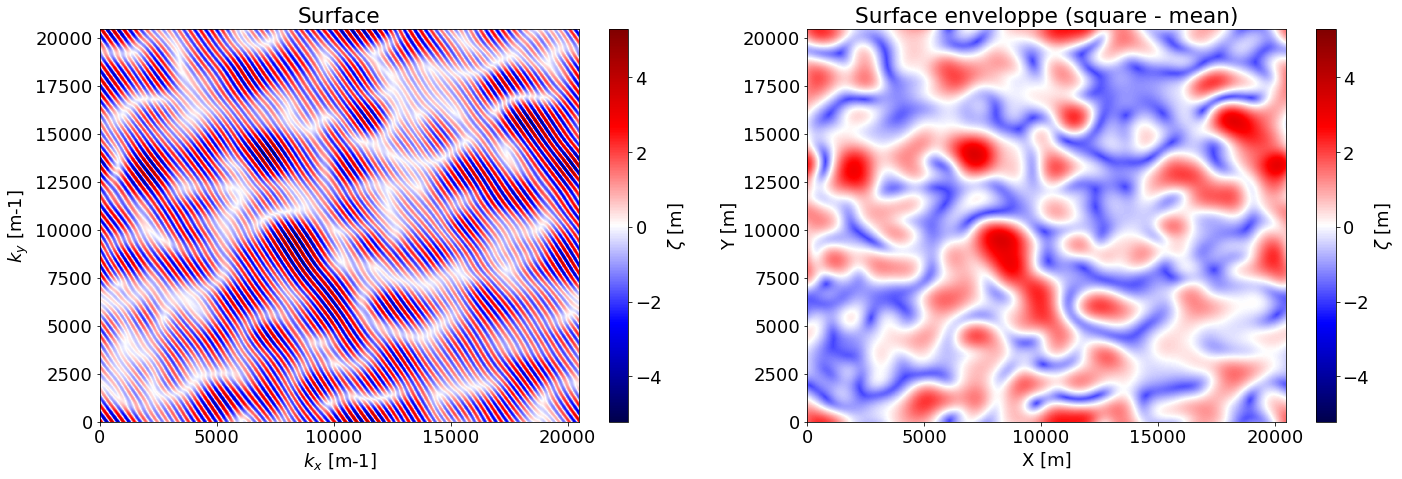

In [4]:
## Figure Surface et Surface Enveloppe ###########################""
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)

im=axs[0].pcolormesh(X,Y,S2D_r,cmap='seismic',norm = mcolors.Normalize(vmin=S1.min(), vmax=S1.max()))
_=plt.colorbar(im,ax=axs[0],label='$\zeta$ [m]')
_=axs[0].set_xlabel('$k_x$ [m-1]')
_=axs[0].set_ylabel('$k_y$ [m-1]')
_=axs[0].set_title('Surface')


A = np.sqrt(S2D_r**2+S2D_r**2)
B=A-np.mean(A.flatten())

im=axs[1].pcolormesh(X,Y,B,cmap='seismic',norm = mcolors.Normalize(vmin=S1.min(), vmax=S1.max()))
_=plt.colorbar(im,ax=axs[1],label='$\zeta$ [m]')

_=axs[1].set_xlabel('X [m]')
_=axs[1].set_ylabel('Y [m]')
_=axs[1].set_title('Surface enveloppe (square - mean)')
_=plt.tight_layout()

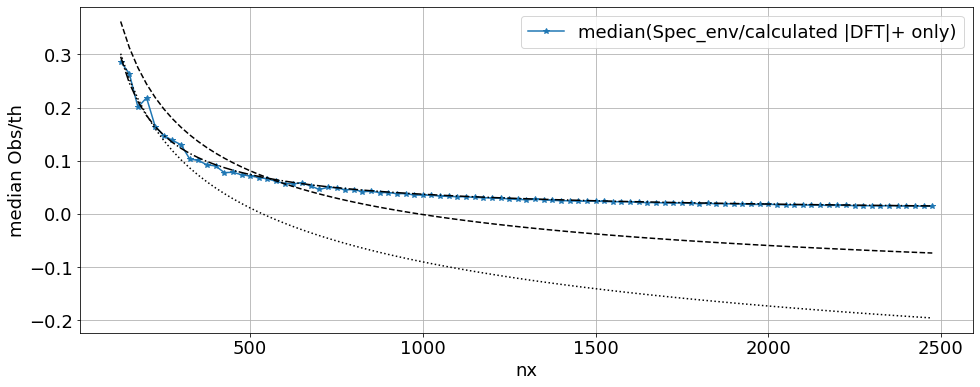

In [104]:
plt.figure(figsize=(16,6))
# plt.plot(nxs,med[0,:],'-*',label = 'median(Spec_env/calculated DFT+ and DFT-)')
# plt.plot(nxs,med[1,:],'-*',label = 'median(Spec_env/calculated DFT+ only)')
plt.plot(nxs,med[2,:],'-*',label = 'median(Spec_env/calculated |DFT|+ only)')
plt.plot(nxs,-0.2+2*np.pi/(np.sqrt(nxs)),'--k')
plt.plot(nxs,(np.sqrt(ny)/(np.sqrt(1.5)*nxs)),'-.k')
plt.plot(nxs,-1.+2*np.pi/np.log(nxs),':k')
plt.xlabel('nx')
plt.ylabel('median Obs/th')
# plt.xscale('log')
# plt.yscale('log')
plt.grid(True)
plt.legend()

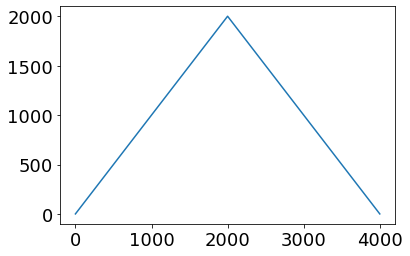

In [105]:
## Testing numpy convolution

Xa=np.ones((2000))
Xb=np.convolve(Xa,Xa,'full')
plt.plot(Xb)

4*sdt(eta) =  5.999999999999882
6.014780353971045 < H_1/3 <  6.014780353971045


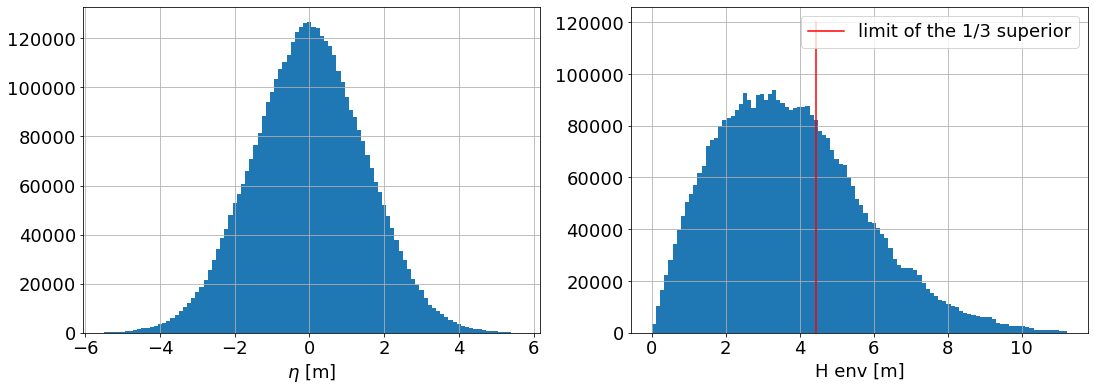

In [6]:
A = np.sqrt(S1**2+S2**2) # S1 is real part, S2 is imaginary part
B = 2*A # multiply by 2 to have the wave height and not the wave amplitude
Hs131 = np.quantile(B,0.66)
Hs132 = np.quantile(B,0.67)
print('4*sdt(eta) = ',4*np.std(S1))

print(np.nanmean(B[B>=Hs132]),'< H_1/3 < ',np.nanmean(B[B>=Hs132]))


fig,axs=plt.subplots(1,2,figsize=(18,6))
_=axs[0].grid(True)
_=axs[0].hist((S1.flatten()),bins=100)
_=axs[0].set_xlabel('$\eta$ [m]')
_=axs[1].grid(True)
_=axs[1].hist(B.flatten(),bins=100)
_=axs[1].plot([Hs131,Hs131],[0,120000],'-r',label='limit of the 1/3 superior')
_=axs[1].legend()
_=axs[1].set_xlabel('H env [m]')


Hs =  12.031815718228787
med =  1.3042065287342395


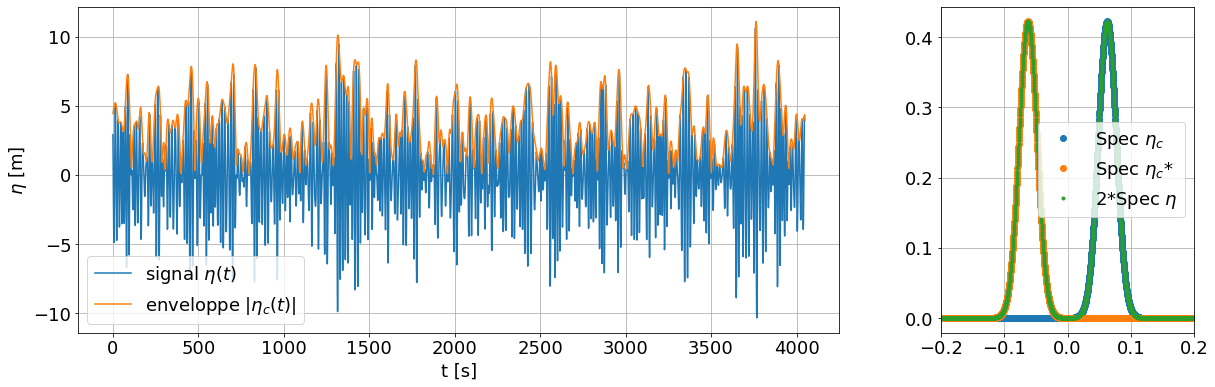

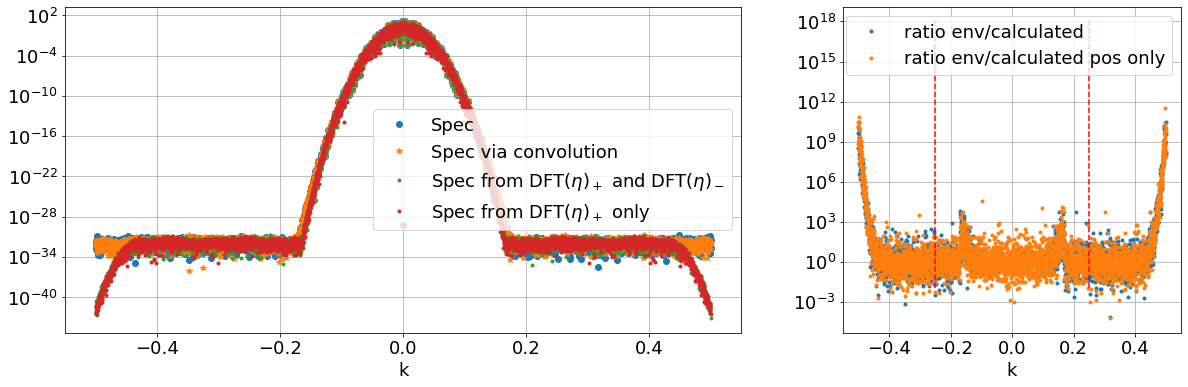

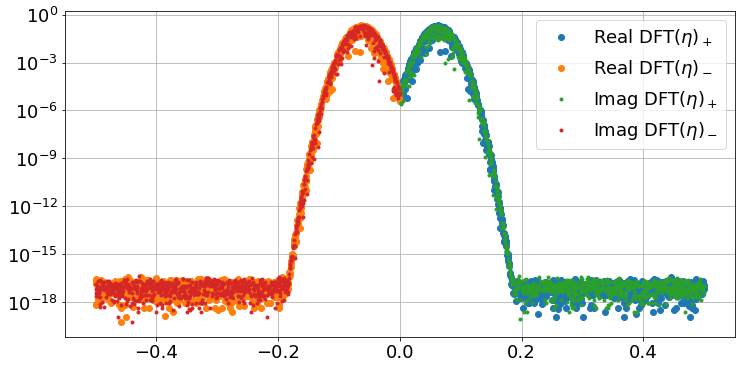

In [5]:
#### 1D #################################################################

####### Set-up the problem ####################################""
dt = 1
n = 4048
Tvec=dt*np.arange(0,n)
dk = 2*np.pi/(dt*n)
sig = 0.01

f = np.fft.fftfreq(n, d=dt)
freq_shifted = np.fft.fftshift(f)
Tp = 16
fp = 1/Tp
Hs = 12
## Define a spectrum #################################
E_k = (Hs)**2/np.sqrt(2*np.pi)*np.exp((-0.5*(f-fp)**2/sig**2))

sumZ1=4*np.sqrt(sum(E_k.flatten()*dk)) 
print('Hs = ',sumZ1)

### Generate surface(t) ##################################
rng = np.random.default_rng(1)
rg = rng.uniform(low=0.0, high=1.0, size=(n))

zhats=(np.sqrt(2*E_k*dk)*np.exp(1j*2*np.pi*rg))
eta_c = np.fft.ifft(zhats,norm="forward")
eta_r = np.real(eta_c)
eta_i = np.imag(eta_c)
### Compute enveloppe ##################################################################
A = (eta_r**2+eta_i**2) # eta_r is real part, eta_i is imaginary part
B = A - np.mean(A) # B : surface enveloppe (squared)


### Go to frequency domain (DFT = Discrete Fourier Transform) ##########################
# with the conventions that the normalization is made 'forward',
# i.e. DFT(x)(k)=X(k) = 1/N * sum_n=0^N x(n)* e^{-i*2*pi*n*k/N}
#
# => the Convolution theorem then writes :
#    ##########################################################
#    ##                                                    ####
#    ##     DFT(x conv y) = N * X*Y = N * DFT(x)*DFT(y)    ####
#    ##                                                    ####
#    ##     DFT(x * y) = X conv Y = DFT(x) conv DFT(y)     ####
#    ##                                                    ####
#    ##########################################################
#

# ---- Spectrum of B = spectrum of enveloppe ---------------
Spec_env = np.abs(np.fft.fft(B,norm='forward'))**2
Spec_env_shifted = np.fft.fftshift(Spec_env)

# ---- compute DFT for eta_c, eta_c* and eta_r -------------
DFT_eta_c0 = np.fft.fft(eta_c,norm='forward')
DFT_eta_c_conj0 = np.fft.fft(np.conjugate(eta_c),norm='forward')
DFT_eta_c = np.fft.fftshift(DFT_eta_c0)
DFT_eta_c_conj = np.fft.fftshift(DFT_eta_c_conj0)

DFT_eta_r0 = np.abs(np.fft.fft(eta_r,norm='forward'))
DFT_eta_r = np.fft.fftshift(DFT_eta_r0)
DFT_eta_rold0 = (np.fft.fft(eta_r,norm='forward'))
DFT_eta_rold = np.fft.fftshift(DFT_eta_rold0)


### Convolve directly the DFT of eta_c and eta_c* = eta_c_conj ####################
#    DFT(|A|**2) = DFT(eta_c * eta_c_conj) = DFT(eta_c) conv DFT(eta_c_conj)
conv_DFT0 = np.convolve(DFT_eta_c,DFT_eta_c_conj,'full')
conv_DFT = np.abs(conv_DFT0[n//2:n//2+n])**2
conv_DFT[n//2]=Spec_env_shifted[n//2]

### Use the identity : DFT(eta_c) = 2 * DFT(eta)_+, 
#  where DFT(.)_+ is the DFT(.) with values =0 for negative frequencies 
#  and DFT(.)_- is the DFT(.) with values =0 for positive frequencies
#
# /!\ watch out !!!! when initializing a vector you must specify dtype=np.complex128
# if you don't specify that it is meant to be a complex vector the im part is purely removed !!!!
#
DFT_eta_r_pos = np.zeros(DFT_eta_r.shape,dtype=np.complex128)
DFT_eta_r_pos[n//2:] = DFT_eta_rold[n//2:]#*(1+1j)*np.sqrt(2)

DFT_eta_r_neg = np.zeros(DFT_eta_r.shape,dtype=np.complex128)
DFT_eta_r_neg[0:n//2] = DFT_eta_rold[0:n//2]#/np.sqrt(2**3)

###  Write the convolution using DFT(eta)_+ and DFT(eta)_-, instead of DFT(eta_c)
conv_DFT_bis0 = np.convolve(2*DFT_eta_r_pos,2*DFT_eta_r_neg,'full')
conv_DFT_bis = conv_DFT_bis0[n//2:n//2+n]
conv_DFT_bis[n//2]=Spec_env_shifted[n//2]

###  Write the convolution using DFT(eta)_+ ONLY, instead of DFT(eta_c) (using the symmetry of DFT(eta))
conv_DFT_ter0 = np.convolve(2*DFT_eta_r_pos,2*np.flip(DFT_eta_r_pos),'full')
conv_DFT_ter = conv_DFT_ter0[n//2:n//2+n]

### take the modulus squared
Spec_calculated_env = np.abs(conv_DFT_bis)**2
Spec_calculated_env[n//2]=Spec_env_shifted[n//2]
Spec_calculated_env_pos = np.abs(conv_DFT_ter)**2 
Spec_calculated_env_pos[n//2]=Spec_env_shifted[n//2]

############################  FIGURES ###################################################################
# --- Figure of the position of the problem: enveloppe spectrum vs convolutions #########################
fig,axs=plt.subplots(1,2,figsize=(20,6), gridspec_kw={'width_ratios': [3, 1]})
axs[0].plot(Tvec,eta_r,label='signal $\eta(t)$')
axs[0].plot(Tvec,np.abs(eta_c),label='enveloppe $|\eta_c(t)|$')
axs[0].grid(True)
axs[0].set_xlabel('t [s]')
axs[0].set_ylabel('$\eta$ [m]')
axs[0].legend()

axs[1].plot(freq_shifted,np.abs(DFT_eta_c),'o',label='Spec $\eta_c$')
axs[1].plot(freq_shifted,np.abs(DFT_eta_c_conj),'o',label='Spec $\eta_c$*')
axs[1].plot(freq_shifted,2*np.abs(DFT_eta_r),'.',label='2*Spec $\eta$')
axs[1].grid(True)
axs[1].set_xlim((-0.2,0.2))
axs[1].legend()

# --- Figure of what we want : enveloppe spectrum vs convolutions #######################################
fig,axs=plt.subplots(1,2,figsize=(20,6),gridspec_kw={'width_ratios': [2, 1]})
_=axs[0].plot(freq_shifted,Spec_env_shifted,'o',label='Spec')
_=axs[0].plot(freq_shifted,conv_DFT,'*',label='Spec via convolution')
_=axs[0].plot(freq_shifted,Spec_calculated_env,'.',label='Spec from DFT($\eta$)$_+$ and DFT($\eta$)$_-$')
_=axs[0].plot(freq_shifted,Spec_calculated_env_pos,'.',label='Spec from DFT($\eta$)$_+$ only')
_=axs[0].grid(True)
# _=plt.ylim((10**-10,10**2))
_=axs[0].set_xlabel('k')
_=axs[0].set_yscale('log')
_=axs[0].legend()

# --- Figure of ratio between spec env / spec calculated ##############################################
_=axs[1].plot(freq_shifted,Spec_env_shifted/Spec_calculated_env,'.',label='ratio env/calculated')
_=axs[1].plot(freq_shifted,Spec_env_shifted/Spec_calculated_env_pos,'.',label='ratio env/calculated pos only')
_=axs[1].plot([freq_shifted[n//4],freq_shifted[n//4]],[10**-2,10**18],'--r')
_=axs[1].plot([freq_shifted[3*n//4],freq_shifted[3*n//4]],[10**-2,10**18],'--r')
_=axs[1].grid(True)
_=axs[1].set_xlabel('k')
_=axs[1].set_yscale('log')
_=axs[1].legend()

# --- Figure of spectrum(eta) with eta the real signal (positive and negative parts) ###################
_=plt.figure(figsize=(12,6))
_=plt.plot(freq_shifted,np.real(DFT_eta_r_pos),'o',label='Real DFT($\eta$)$_+$')
_=plt.plot(freq_shifted,np.real(DFT_eta_r_neg),'o',label='Real DFT($\eta$)$_-$')
_=plt.plot(freq_shifted,np.imag(DFT_eta_r_pos),'.',label='Imag DFT($\eta$)$_+$')
_=plt.plot(freq_shifted,np.imag(DFT_eta_r_neg),'.',label='Imag DFT($\eta$)$_-$')
_=plt.grid(True)
_=plt.yscale('log')
_=plt.legend()

med = np.median(Spec_env_shifted[n//4:3*n//4]/Spec_calculated_env_pos[n//4:3*n//4])
print('med = ',med)

Sum of abs =  60.59886895643004
Sum of Re =  2.9075018479743906
Sum of Im =  -4.440892098500626e-16

ratio Re/abs =  0.047979473842405446
ratio Im/abs =  -7.328341559796407e-18

ratio median(Re/abs) =  0.0025891992534413403
ratio median(Im/abs) =  -0.0033393729961014394


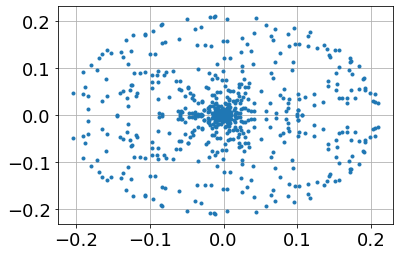

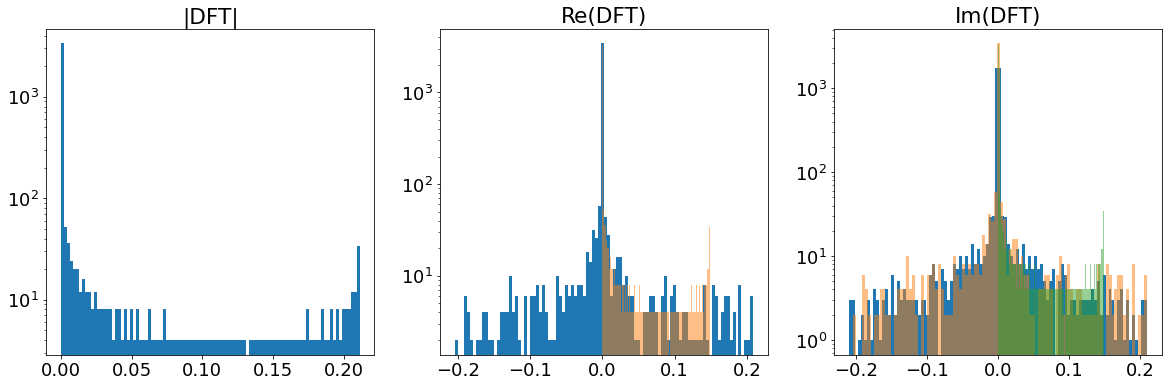

In [23]:
DFT_eta_r0 = (np.fft.fft(eta_r,norm='forward'))
DFT_eta_rold = np.fft.fftshift(DFT_eta_r0)

sum_abs = np.sum(np.abs(DFT_eta_rold))
sum_re = np.sum(np.real(DFT_eta_rold))
sum_im = np.sum(np.imag(DFT_eta_rold))

real_false = np.abs(DFT_eta_rold)/np.sqrt(2)
imag_false = np.abs(DFT_eta_rold)/np.sqrt(2)

ratio_r = sum_re/sum_abs
ratio_i = sum_im/sum_abs

ratio_r_mean = np.nanmean(np.real(DFT_eta_rold)/np.abs(DFT_eta_rold))
ratio_i_mean = np.nanmean(np.imag(DFT_eta_rold)/np.abs(DFT_eta_rold))

print('Sum of abs = ',sum_abs)
print('Sum of Re = ',sum_re)
print('Sum of Im = ',sum_im)
print('')
print('ratio Re/abs = ',ratio_r)
print('ratio Im/abs = ',ratio_i)
print('')
print('ratio median(Re/abs) = ',ratio_r_mean)
print('ratio median(Im/abs) = ',ratio_i_mean)

plt.figure()
plt.plot(np.real(DFT_eta_rold),np.imag(DFT_eta_rold),'.')
plt.grid(True)

fig,axs=plt.subplots(1,3,figsize=(20,6))
axs[0].hist(np.abs(DFT_eta_rold),bins=100)
axs[0].set_title('|DFT|')
axs[0].set_yscale('log')
axs[1].hist(np.real(DFT_eta_rold),bins=100)
h=axs[1].hist(real_false,bins=100,alpha=0.5)
# h.set('alpha',0.5)
axs[1].set_title('Re(DFT)')
axs[1].set_yscale('log')
axs[2].hist(np.imag(DFT_eta_rold),bins=100)
h=axs[2].hist(np.real(DFT_eta_rold),bins=100,alpha=0.5)
h=axs[2].hist(real_false,bins=100,alpha=0.5)
axs[2].set_title('Im(DFT)')
axs[2].set_yscale('log')

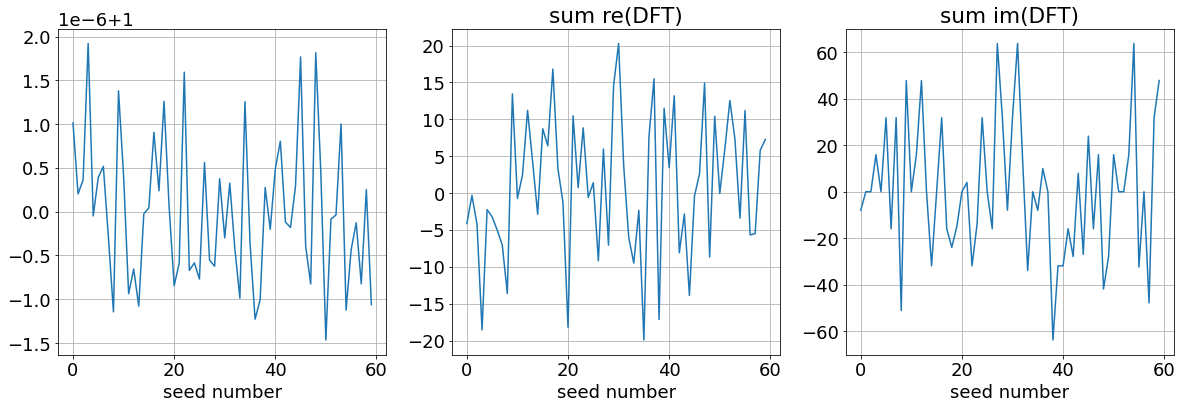

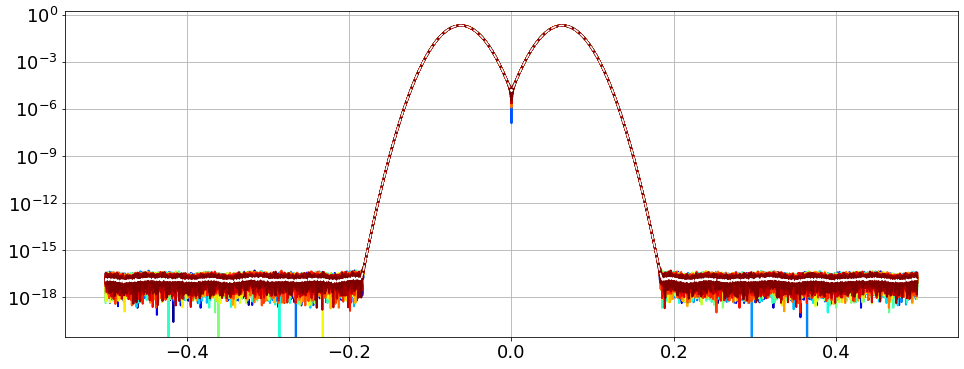

In [33]:
#####  Investigate variations with different seed numbers #########################""
ns = 60

sum_abs = np.zeros(ns)
sum_re = np.zeros(ns)
sum_im = np.zeros(ns)

abs_DFT = np.zeros((n,ns))

for see in range(ns):
    rng = np.random.default_rng(see)
    rg = rng.uniform(low=0.0, high=1.0, size=(n))

    zhats=(np.sqrt(2*E_k*dk)*np.exp(1j*2*np.pi*rg))
    eta_c = np.fft.fftshift(np.fft.ifft(zhats,norm="forward"))
    eta_r = np.real(eta_c)
    eta_i = np.imag(eta_c)
    DFT_eta_r0 = (np.fft.fft(eta_r,norm='forward'))
    DFT_eta_rold = np.fft.fftshift(DFT_eta_r0)

    sum_abs[see] = np.sum(np.abs(DFT_eta_rold))
    sum_re[see] = np.sum(np.real(DFT_eta_rold))
    sum_im[see] = np.sum(np.imag(DFT_eta_rold))
    abs_DFT[:,see] = np.abs(DFT_eta_rold)

fig,axs=plt.subplots(1,3,figsize=((20,6)))
axs[0].plot(np.arange(ns),sum_abs/np.mean(sum_abs),label='sum |DFT|')
axs[0].grid(True)
axs[0].set_xlabel('seed number')
# axs[0].set_title('sum |DFT|')
axs[1].plot(np.arange(ns),sum_re/np.mean(sum_re),label='sum re(DFT)')
axs[1].grid(True)
axs[1].set_xlabel('seed number')
axs[1].set_title('sum re(DFT)')
axs[2].plot(np.arange(ns),sum_im/np.mean(sum_im),label='sum im(DFT)')
axs[2].grid(True)
axs[2].set_xlabel('seed number')
axs[2].set_title('sum im(DFT)')

mean_abs_DFT = np.mean(abs_DFT,axis=1)

plt.figure(figsize=(16,6))
colors = plt.cm.jet(np.linspace(0,1,ns))
for see in range(ns):
    plt.plot(freq_shifted,abs_DFT[:,see],color=colors[see],linewidth=2)

plt.plot(freq_shifted,mean_abs_DFT,'--w')
plt.grid(True)
plt.yscale('log')

In [ ]:
module = np.sqrt(re**2+im**2) si RE=IM 
module = np.sqrt(re**2 + re**2)=np.sqrt(2 re**2) = np.sqrt(2)*re

z = re + i *im
z = mod/np.sqrt(2) + i*mod/np.sqrt(2)



In [39]:
Z2 = np.abs(np.fft.fft2(S1)/(nx*ny))**2/(dkx*dky)

Hs_surface= 4*np.std(S1.real.flatten())
print('Hs_surface not rolled = ',Hs_surface)

# Hs_surface= 4*np.std(S1bis.real.flatten())
# print('Hs_surface rolled = ',Hs_surface)

Hs_spectrum = 4*np.sqrt(sum(Z1.flatten()*dkx*dky)) # % variance should be 1. for Gaussian
print('Hs_spectrum = ',Hs_spectrum)

# Z2 = np.abs(np.fft.fft2(S1+1j*S2))**2/(2*dkx*dky)
Hs_spectrum2 = 4 * np.sqrt(sum(Z2.flatten()*dkx*dky))
print('Hs_spectrum 2 = ',Hs_spectrum2)


Gaussian spectrum selected. Available options:
 - Hs, sk_theta, sk_k. 
With (sk_k, sk_theta) the sigma values for the k-axis along the main direction and perpendicular to it respectively 
 Other options (common to all spectrum types) are : nx, ny, dx, dy, T0, theta_m, D
Hs for Gaussian :  3.9999999999999636
Hs_surface not rolled =  4.000221458404797
Hs_spectrum =  3.999999999999816
Hs_spectrum 2 =  4.001182196307283


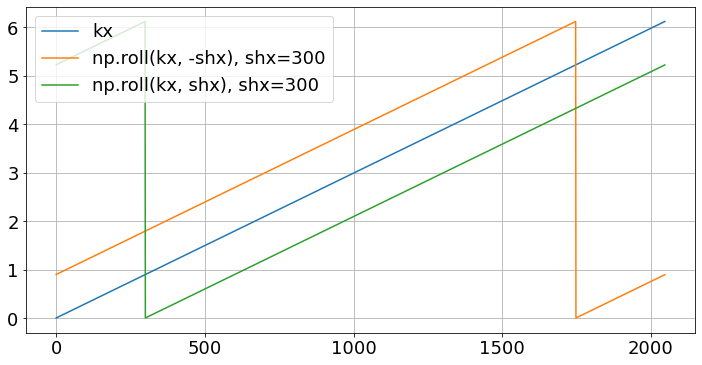

In [4]:
### --- investigate np.roll 
nx1=2048
dkx1=0.0025
kx1=np.linspace(0,(nx-1)*dkx1,nx1)

shx1 = 300
kxs1=np.roll(kx1,-shx1)
kxs2 = np.roll(kx1,shx1)
# kxs1[:shx1]=kxs1[:shx1]-kx1[-1]-dkx1
plt.figure(figsize=(12,6))
plt.plot(kx1,label='kx')
plt.plot(kxs1,label='np.roll(kx, -shx), shx='+str(shx1))
plt.plot(kxs2,label='np.roll(kx, shx), shx='+str(shx1))
plt.grid(True)
plt.legend()

In [7]:
dkx

0.002575075945565404

In [37]:
def FFT2D(arraya,nxa,nya,dx,dy,n,isplot=0):
# function to do a FFT 2D 
# nxa, nya : size of arraya
# dx,dy : resolution of arraya
# n : number of tiles in each directions ... 
# 
# Eta is PSD of 1st image (arraya) 
# Etb is PSD of 2st image (arraya) 
    mspec=n**2+(n-1)**2

    nxtile=int(np.floor(nxa/n)) 
    nytile=int(np.floor(nya/n))
    print('nxtile : ',nxtile)
    print('nytile : ',nytile)

    dkxtile=2*np.pi/(dx*nxtile)   
    dkytile=2*np.pi/(dy*nytile)

    shx = int(nxtile//2)
    shy = int(nytile//2)

    ### --- prepare wavenumber vectors -------------------------
    # wavenumbers starting at zero
    kx=np.linspace(0,(nxtile-1)*dkxtile,nxtile)
    ky=np.linspace(0,(nytile-1)*dkytile,nytile)
    # Shift wavenumbers to have zero in the middle
    kxs=np.roll(kx,-shx)
    kys=np.roll(ky,-shy)

    # change the first half to have negative wavenumber
    kxs[:shx+1]=kxs[:shx+1]-kx[-1]-dkxtile
    kys[:shy+1]=kys[:shy+1]-ky[-1]-dkytile

    kx2,ky2 = np.meshgrid(kxs,kys)
    if isplot:
        X = np.arange(0,nxa*dx,dx) # from 0 to (nx-1)*dx with a dx step
        Y = np.arange(0,nya*dy,dy)

    ### --- prepare Hanning windows for performing fft and associated normalization ------------------------

    hanningx=(0.5 * (1-np.cos(2*np.pi*np.linspace(0,nxtile-1,nxtile)/(nxtile-1))))
    hanningy=(0.5 * (1-np.cos(2*np.pi*np.linspace(0,nytile-1,nytile)/(nytile-1))))
    # 2D Hanning window
    hanningxy=np.atleast_2d(hanningx)*np.atleast_2d(hanningy).T 

    wc2x=1/np.mean(hanningx**2);                              # window correction factor
    wc2y=1/np.mean(hanningy**2);                              # window correction factor

    normalization = (wc2x*wc2y)/(dkxtile*dkytile)

    ### --- Initialize Eta = mean spectrum over tiles ---------------------

    Eta=np.zeros((nytile,nxtile))
    Eta_all=np.zeros((nytile,nxtile,mspec))
    if isplot:
        fig1,ax1=plt.subplots(figsize=(12,6))
        ax1.pcolormesh(X,Y,arraya)
        colors = plt.cm.seismic(np.linspace(0,1,mspec))

    ### --- Calculate spectrum for each tiles ----------------------------
    for m in range(mspec):
        ### 1. Selection of tile ------------------------------
        if (m<n**2):
            i1=int(np.floor(m/n)+1)
            i2=int(m+1-(i1-1)*n)
            
            ix1 = nxtile*(i1-1)
            ix2 = nxtile*i1-1
            iy1 = nytile*(i2-1)
            iy2 = nytile*i2-1
            
#                 array1=double(arraya(nx*(i1-1)+1:nx*i1,ny*(i2-1)+1:ny*i2));
    #        Select a 'tile' i.e. part of the surface : main loop ---------
            
            array1=np.double(arraya[iy1:iy2+1,ix1:ix2+1])
            if isplot:
                ax1.plot(X[[ix1,ix1,ix2,ix2,ix1]],Y[[iy1,iy2,iy2,iy1,iy1]],'-',color=colors[m],linewidth=2)
        else:
    #        # -- Select a 'tile' overlapping (50%) the main tiles ---
    #        %%%%%%%%%%%%%%% now shifted 50% , like Welch %%%%%%%%%%%%%%
            i1=int(np.floor((m-n**2)/(n-1))+1)
            i2=int(m+1-n**2-(i1-1)*(n-1))
        
            
            ix1 = nxtile*(i1-1)+shx 
            ix2 = nxtile*i1+shx-1
            iy1 = nytile*(i2-1)+shy
            iy2 = nytile*i2+shy-1
            
            array1=np.double(arraya[iy1:iy2+1,ix1:ix2+1])
            if isplot:
                ax1.plot(X[[ix1,ix1,ix2,ix2,ix1]],Y[[iy1,iy2,iy2,iy1,iy1]],'-',color=colors[m],linewidth=2)

        ### 2. Work over 1 tile ------------------------------ 
        tile_centered=array1-np.mean(array1.flatten())
        tile_by_windows = (tile_centered)*hanningxy

        # 
        tileFFT = np.fft.fft(tile_by_windows,norm="forward")#/(nx*ny)
        tileFFT_shift = np.roll(tileFFT,(-shy,-shx),axis=(0,1))
        Eta_all[:,:,m] = (abs(tileFFT_shift)**2) *normalization
        Eta[:,:] = Eta[:,:] + (abs(tileFFT_shift)**2) *normalization #          % sum of spectra for all tiles

    return Eta/mspec,Eta_all,kx2,ky2

In [3]:
def surface_from_Z1kxky_gaussian_phase(Z1,kX,kY,i,nx=None,ny=None,dx=None,dy=None,dkx=None,dky=None):
    # /!\ Watch out : shape(S) = (ny,nx)
    # usually when doing X,Y=np.meshgrid(x,y) with size(x)=nx and size(y)=ny => size(X)=size(Y)= (ny,nx)
    kX0 = np.unique(kX)
    kY0 = np.unique(kY)
    if nx==None:
        nx = Z1.shape[1]
    if ny==None:
        ny = Z1.shape[0]
    shx = np.floor(nx/2-1)
    shy = np.floor(ny/2-1)
    if (dx==None):
        if dkx == None:
            dx = 2*np.pi/((kX0[1] - kX0[0])*nx)
        else:
            dx = 2*np.pi/(dkx*nx)

    if (dy==None):
        if dky == None:
            dy = np.floor(2*np.pi/((kY0[1] - kY0[0])*ny))
        else:
            dy = 2*np.pi/(dky*ny)

    if (dkx==None):
        dkx = 2*np.pi/(dx*nx)
    if (dky==None):
        dky = 2*np.pi/(dy*ny)
    ########################################################################################
    # SIDE NOTE :       									#
    # obtain dkx, dky from dx and dy in order to account for eventual rounding of np.pi	#
    # considering that dkx has been defined according to the surface requisite (nx,dx)	#
    # Eg:											#
    # # initialisation to compute spectrum							#
    # nx = 205										#
    # dx = 10										#
    # dkx = 2*np.pi/(dx*nx)								#
    # kX0 = dkx*np.arange(-nx//2+1,nx//2+1)						#
    # 											#
    # # Compute from kX0 and nx (found from kX0.shape)					#
    # dkx2 = kX0[1] - kX0[0]								#
    # dxbis = (2*np.pi/(dkx2*nx))								#
    # dkx3 = 2*np.pi/(dxbis*nx)								#
    #											#
    # print('dkx = ',dkx)     		=> 0.0030649684425266273			#
    # print('dkx2 = ',dkx2) 		=> 0.0030649684425266277			#
    # print('dkx3 = ',dkx3) 		=> 0.0030649684425266273			#
    #											#
    ########################################################################################
    rng = np.random.default_rng(i)
    rg = rng.normal(0,1,(ny,nx))
    # rg = rng.uniform(low=0.0, high=1.0, size=(ny,nx))
    zhats=np.roll(np.sqrt(2*Z1*dkx*dky)*np.exp(1j*2*np.pi*rg),(-int(shy),-int(shx)),axis=(0,1))
    ky2D=np.roll(kY,(-int(shy),-int(shx)),axis=(0,1)) # checks that ky2D(1,1)=0 ... 
    kx2D=np.roll(kX,(-int(shy),-int(shx)),axis=(0,1)) # checks that kx2D(1,1)=0 ... 

    S1 = np.real(np.fft.ifft2(zhats))*(nx*ny)
    # S1 = np.real(np.fft.ifft2(zhats))*(nx**2)
    # # Bertrand's convolution... 
    # F2r = np.fft.fft2(rg) 
    # F2Z1 = np.roll(np.sqrt(2*Z1_Gaussian*dkx*dky),(-int(shy),-int(shx)),axis=(0,1))
    # # F2Z1 = np.fft.fft2(2*Z1_Gaussian*dkx*dky)
    # S1 = np.real(np.fft.ifft2(F2r*F2Z1))
    X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
    Y = np.arange(0,ny*dy,dy)

    return S1,X,Y 

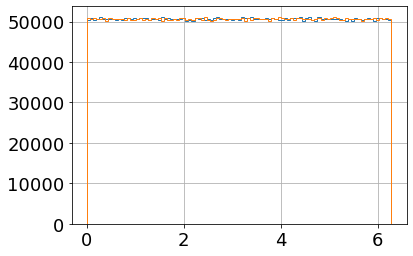

In [8]:
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(ny,nx))
vec_uniform = (2*np.pi*rg)%(2*np.pi)
rg = rng.normal(0,1,(ny,nx))
vec_normal = (2*np.pi*rg)%(2*np.pi)

vec_angles= np.linspace(0,2*np.pi,100)
plt.hist(vec_uniform.flatten(),bins=vec_angles,histtype='step',label='uniform')
plt.hist(vec_normal.flatten(),bins=vec_angles,histtype='step',label='normal')
plt.grid(True)

In [4]:
nxa=2048+400
nya=2048
dx=10
dy=10
n=10

arraya=S1[:nya+1,:]
kXX = kX[:nya+1,:]
kYY = kY[:nya+1,:]
print('shape arraya : ',arraya.shape)
print('shape kXX : ',kXX.shape)
print('shape kYY : ',kYY.shape)

shape arraya :  (2049, 2448)
shape kXX :  (2049, 2448)
shape kYY :  (2049, 2448)


1276


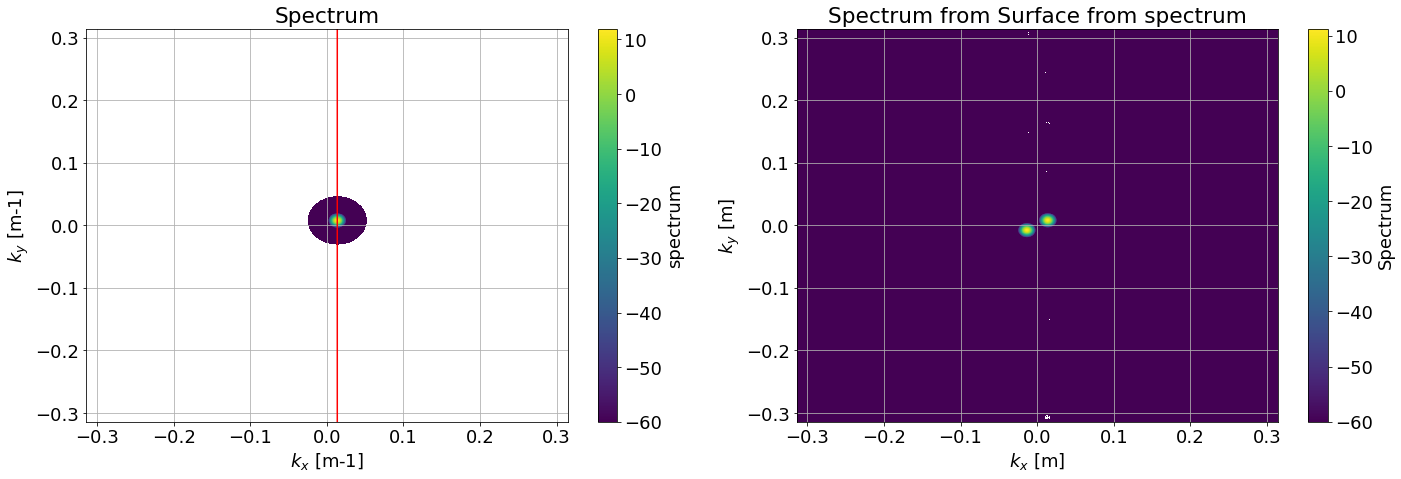

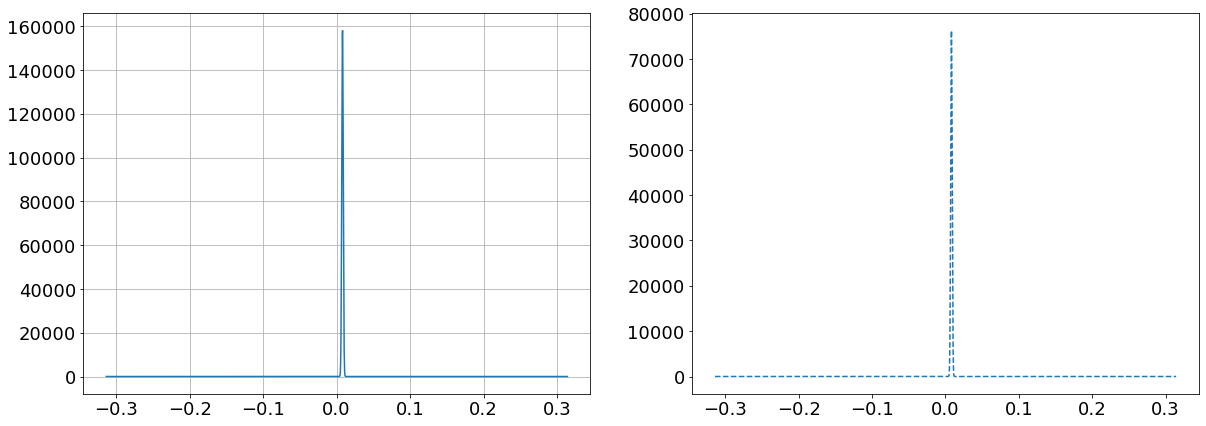

In [10]:
fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
im=axs[0].pcolormesh(kX,kY,np.log(Z1),vmin=-60)
indmax=np.argmax(np.sum(Z1,axis=0))
print(indmax)
_=axs[0].plot(kX[:,indmax],kY[:,indmax],'-r')
_=plt.colorbar(im,ax=axs[0],label='spectrum')
_=axs[0].grid(True)
_=axs[0].set_xlabel('$k_x$ [m-1]')
_=axs[0].set_ylabel('$k_y$ [m-1]')
_=axs[0].set_title('Spectrum')

# im=axs[1].pcolormesh(X,Y,S1,cmap='viridis',norm = mcolors.Normalize(vmin=S1.min(), vmax=S1.max()))
# _=plt.colorbar(im,ax=axs[1],label='$\zeta$ [m]')
Z2rolled  = np.roll(Z2,(-int(ny//2),-int(nx//2)),axis=(0,1))
im=axs[1].pcolormesh(kX,kY,np.log(Z2rolled),vmin=-60)#,vmax=5,vmin=-720)
_=plt.colorbar(im,ax=axs[1],label='Spectrum')
_=axs[1].grid(True)
_=axs[1].set_xlabel('$k_x$ [m]')
_=axs[1].set_ylabel('$k_y$ [m]')
_=axs[1].set_title('Spectrum from Surface from spectrum')
_=plt.tight_layout()


fig,axs=plt.subplots(1,2,figsize=(20,7))#,sharey=True,sharex=True)
axs[0].plot(kY[:,indmax],Z1[:,indmax],'-')
axs[1].plot(kY[:,indmax],Z2rolled[:,indmax],'--')
axs[0].grid(True)

# im=axs[1].pcolormesh(kX,kY,np.log(np.abs(Z11-Z22)))
# plt.colorbar(im,ax=axs[1])

In [ ]:
E(k) = |S_chapo1|**2/(nfft*delta_k)

S_chapo1 = FTT(Surface = S1)

Env = S1*S1_conj

FFT(Env) = FFT(S1) conv FFT(S1_conj)

DSP_Env_carre = |FFT(Env)|**2 / (nfft * delta_k)
DSP_Env_carre = |FFT(S1) conv FFT(S1_conj)|**2/(nfft * delta_k)


Convolution avant module au carre 
integral 
TF de la racine ? 


nxtile :  153
nytile :  128


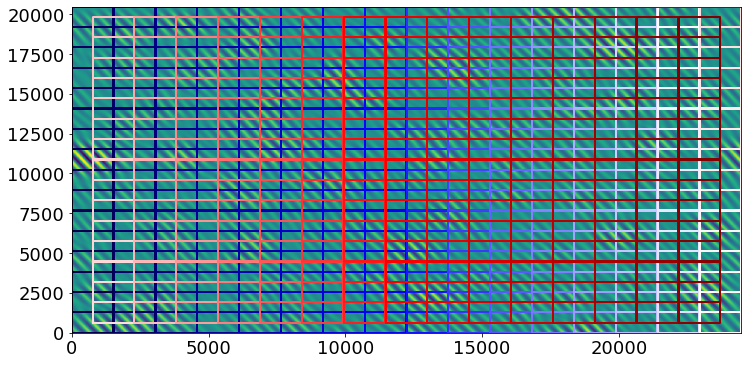

In [5]:
nxa=2448
nya=2048
dx=10
dy=10
n=16
arraya= S1[:nya,:]
# arraya=S1

Etan,Eta_all,kx2,ky2 = FFT2D(arraya,nxa,nya,dx,dy,n,isplot=1)

In [13]:
## investigate size ring for Hs calculation
def fly_over_track_v051_radius(X,Y,S1,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,offset_range,radi_wfm,radi1,radi2):
    ny_mid = len(np.unique(Y))//2
    Xalt = np.zeros((nsamp,1))
    Hs_retrack = np.zeros((nsamp,1))
    Hs_std_disk = np.zeros((nsamp,1))
    Hs_std_ring = np.zeros((nsamp,1))
    waveforms=np.zeros((nsamp,len(edges_ref)-1))

    # Footprint definition 
    dx = X[1]-X[0]
    dy = Y[1]-Y[0]
    footprint=np.ones((2*nxa+1,2*nxa+1))
    footprint_disk=np.ones((2*nxa+1,2*nxa+1))
    footprint_ring=np.ones((2*nxa+1,2*nxa+1))
    [Xa,Ya]=np.meshgrid(dx*np.arange(-nxa,nxa+1), dy*np.arange(-nxa,nxa+1))
    dist_ground = (Xa**2+Ya**2)
    footprint[dist_ground > radi_wfm**2]=np.nan
    footprint_disk[dist_ground > radi2**2]=np.nan
    footprint_ring[dist_ground > radi2**2]=np.nan
    footprint_ring[dist_ground < radi1**2]=np.nan

    for isamp in range(nsamp):
#         clear_output(wait=True)
        print(isamp)
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        surf=S1[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        surf_disk=S1[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint_disk
        surf_ring=S1[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint_ring
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-surf)**2)-alti_sat+10
        r[dist_ground > radi_wfm**2]=np.nan  # equivalent to multiplication by footprint

        counts,_=np.histogram(r,bins=edges_ref)
        Hs_retrack[isamp] = simple_retracking_process(counts,edges_ref,wfm_ref=wfm_ref,Hsm_ref=Hsm_ref) 
        waveforms[isamp,:]=counts
        Hs_std_disk[isamp] = 4*np.nanstd(surf_disk.flatten())#/np.sqrt(np.mean(footprint))
        Hs_std_ring[isamp] = 4*np.nanstd(surf_ring.flatten())

    return Hs_std_disk,Hs_std_ring,Hs_retrack,Xalt,waveforms

In [ ]:
radi_wfm=8000
radi1 = np.arange(0,4000,250)
radi2 = np.arange(250,4250,250)
dist_ring_retrack = np.zeros((len(radi1),len(radi2)))
dist_disk_retrack = np.zeros((len(radi2),1))

freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite v
alti_sat=519000 # altitude of satellite CFOSAT

# --- edges for range windows ------------
dr = 0.375
edges_max = 70

nHs=251
Hs_max = 25

wfm_ref, Hsm_ref, edges_ref = generate_wvform_database(dr,nHs,edges_max=edges_max,Hs_max=Hs_max,offset=10)

Apix = np.pi*2*alti_sat*dr / (dx**2)
offset_range = 10
nxa=np.floor(radi_wfm/dx).astype(int) # size of radius of footprint in pixel
di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples
    
for idist1 in range(len(radi1)):
    radii1 = radi1[idist1]
    for idist2 in range(len(radi2)):
        radii2 = radi2[idist2]
        if radii1>=radii2:
            dist_ring_retrack[idist1,idist2]=np.nan
        else:
            Hs_std_disk,Hs_std_ring,Hs_retrack,_,_ = fly_over_track_v051_radius(X,Y,S1,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,offset_range,radi_wfm,radii1,radii2)
            dist_ring_retrack[idist1,idist2]=np.sum((Hs_std_ring-Hs_retrack)**2)
            dist_disk_retrack[idist2]=np.sum((Hs_std_disk-Hs_retrack)**2)
            

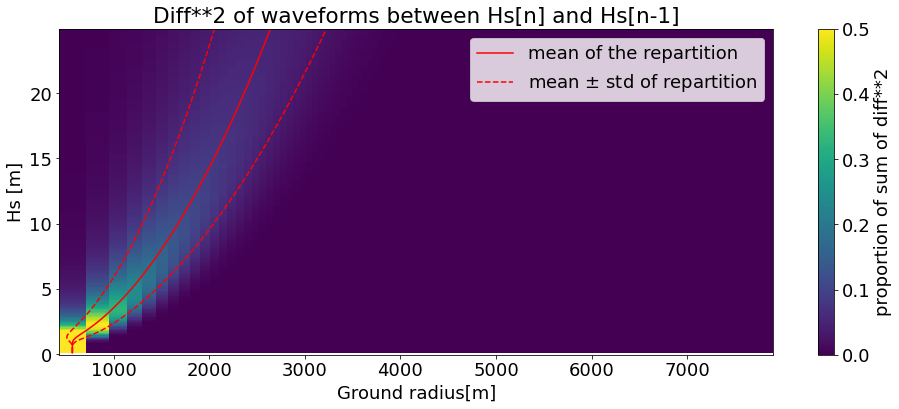

In [54]:
# --- edges for range windows ------------
dr = 0.375
edges_max = 70

nHs=251
Hs_max = 25

wfm_ref, Hsm_ref, edges_ref = generate_wvform_database(dr,nHs,edges_max=edges_max,Hs_max=Hs_max,offset=10)
alti_sat=519000
offset_range=10
range_center = edges_ref[0:-1]+0.5*dr
diff_wfm=np.diff(wfm_ref,axis=0)**2

d_sol = np.sqrt((range_center - offset_range + alti_sat)**2  - alti_sat**2)
indok = np.where(np.isfinite(d_sol))[0]
d_sol2=d_sol[indok]
diff_wfm2 = diff_wfm[:,indok]
diffmax = np.tile(np.sum(diff_wfm2,axis=1),(len(indok),1)).T
diffwfm2norm = diff_wfm2/diffmax

mean_r = np.average(np.tile(d_sol2,(nHs-1,1)), weights=diffwfm2norm,axis=1)
var = np.average((np.tile(d_sol2,(nHs-1,1)) - np.tile(mean_r,(len(indok),1)).T)**2, weights=diffwfm2norm,axis=1)

# fig,axs=plt.subplots(2,1,figsize=(16,10))
fig,axs=plt.subplots(figsize=(16,6))
# im=axs[0].pcolormesh(d_sol2,Hsm_ref[0:-1],diff_wfm2)#/diffmax)
# plt.colorbar(im,ax=axs[0])
# axs[0].set_ylabel('Hs [m]')
im=plt.pcolormesh(d_sol2,Hsm_ref[0:-1],diffwfm2norm,vmin=0,vmax=0.5)
_=plt.plot(mean_r,Hsm_ref[0:-1],'-r',label='mean of the repartition')
_=plt.plot(mean_r+np.sqrt(var),Hsm_ref[0:-1],'--r',label='mean $\pm$ std of repartition')
_=plt.plot(mean_r-np.sqrt(var),Hsm_ref[0:-1],'--r')
_=plt.legend()
_=plt.colorbar(im,label='proportion of sum of diff**2')
_=plt.ylabel('Hs [m]')
_=plt.xlabel('Ground radius[m]')
_=plt.title('Diff**2 of waveforms between Hs[n] and Hs[n-1]')
_=plt.savefig('Theoretical_study_of_R1_and_R2.png')

Hs_surface not rolled =  4.0
Hs_surface rolled =  4.0
Hs_spectrum =  3.9999999999999996
Hs_spectrum 2 =  3.9999999999999996


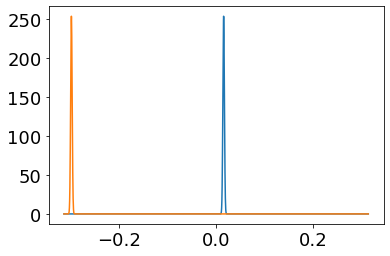

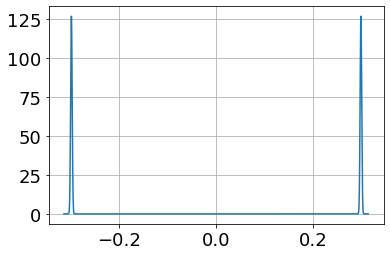

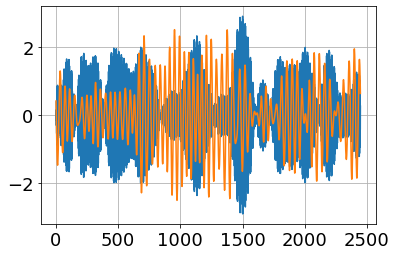

In [72]:
# Z11 = np.roll(Z1,(int(ny//2),int(nx//2)),axis=(0,1))
# C1=np.fft.ifft2(Z11)

kp = 2*np.pi/400
sx=kp*0.1
Z1 = 1/(np.sqrt(2*np.pi)*sx)* np.exp( - 0.5*((kX0-kp)**2/sx**2))
Z1rolled = np.roll(Z1,-int(nx//2))
# Z1rolled[-nx//2:]=Z1rolled[0:nx//2:-1]
rng = np.random.default_rng(0)
rg = rng.uniform(low=0.0, high=1.0, size=(nx))
a1 = np.sqrt(2*Z1*dkx)*np.exp(1j*2*np.pi*rg)
a1bis = np.sqrt(2*Z1rolled*dkx)*np.exp(1j*2*np.pi*rg)

S1 = np.fft.ifft(a1).real*nx
S1bis = np.fft.ifft(a1bis).real*nx

Z2 = np.abs(np.fft.fft(S1bis)/nx)**2/(dkx)
# figure 1
plt.plot(kX0,Z1)
plt.plot(kX0,Z1rolled)
plt.figure()
plt.plot(kX0,Z2)
plt.grid(True)
plt.figure()
plt.plot(S1.real)
plt.plot(S1bis.real)

plt.grid(True)
# Z1 = spectrum
# S1 = surface =ifft(spectrum*random_phases)
Hs_surface= 4*np.std(S1.real.flatten())
print('Hs_surface not rolled = ',Hs_surface)

Hs_surface= 4*np.std(S1bis.real.flatten())
print('Hs_surface rolled = ',Hs_surface)

Hs_spectrum = 4*np.sqrt(sum(Z1.flatten()*dkx)) # % variance should be 1. for Gaussian
print('Hs_spectrum = ',Hs_spectrum)

# Z2 = np.abs(np.fft.fft2(S1+1j*S2))**2/(2*dkx*dky)
Hs_spectrum2 = 4 * np.sqrt(sum(Z2.flatten()*dkx))
print('Hs_spectrum 2 = ',Hs_spectrum2)


In [3]:
ds=xr.open_dataset('/home/mdecarlo/PROJETS/CFOSAT_processing/InvestigateRadius/distR_Hs_04_T0_06_sk_001.nc')
display(ds)

<xarray.Dataset>
Dimensions:            (n: 100, x2: 16, x1: 16, nsamp: 50)
Coordinates:
    radi1              (x1) int64 ...
    radi2              (x2) int64 ...
    Nb_rand            (n) int64 ...
    Hs                 int64 ...
    T0                 int64 ...
    sk_k               float64 ...
Dimensions without coordinates: n, x2, x1, nsamp
Data variables:
    dist_disk_retrack  (n, x2) float64 ...
    dist_ring_retrack  (n, x2, x1) float64 ...
    Hs_retrack         (n, nsamp) float64 ...
    Hs_std_ring        (n, nsamp, x2, x1) float64 ...
    Hs_std_disk        (n, nsamp, x2) float64 ...

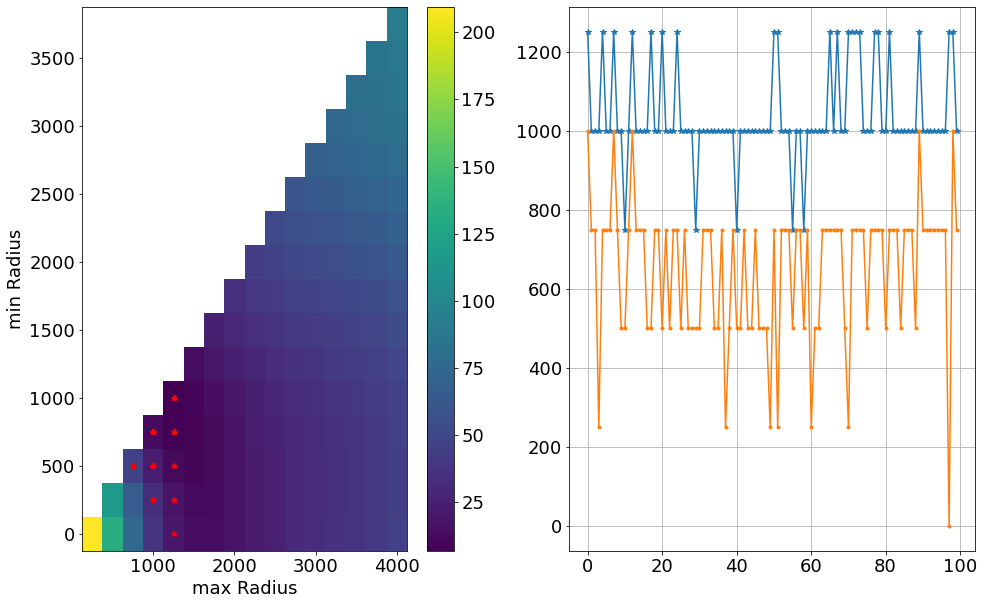

In [19]:
inds=ds.dist_ring_retrack.argmin(dim=['x1','x2'])

# print('radi1 = ',ds.radi1.isel(x1=inds['x1'].compute()).values)

# print('radi2 = ',ds.radi2.isel(x2=inds['x2'].compute()).values)

fig,axs=plt.subplots(1,2,figsize=(16,10))
im=axs[0].pcolormesh(ds.radi2,ds.radi1,ds.dist_ring_retrack.isel(n=0))
plt.colorbar(im,ax=axs[0])
axs[0].plot(ds.radi2.isel(x2=inds['x1'].compute()),
         ds.radi1.isel(x1=inds['x2'].compute()),'*r')
axs[0].set_ylabel('min Radius')
axs[0].set_xlabel('max Radius')
# axs[0].axis('equal')
axs[1].plot(ds.n,ds.radi2.isel(x2=inds['x1'].compute()),'*-')
axs[1].plot(ds.n,ds.radi1.isel(x1=inds['x2'].compute()),".-")
axs[1].grid(True)
# print('\ninds["x1"]:\n',inds['x1'].values)
# print(ds.dist_ring_retrack.min(dim=['x1','x2']).values)

In [6]:
# A=np.sum((Hs_std_ring-Hs_retrack)**2)
B=np.sum((ds.Hs_std_ring.isel(n=0,x1=-1,x2=-1)-ds.Hs_retrack.isel(n=0))**2).values
C = ds.dist_ring_retrack.isel(n=0,x1=-1,x2=-1).values
Hs_std_ring0 = ds.Hs_std_ring.isel(n=0).values
Hs_retrack0 = np.atleast_2d(ds.Hs_retrack.isel(n=0).values)
# plt.plot(Hs_std_ring)
# plt.plot(Hs_std_ring0[:,-1,-1],'.')
# # plt.plot(ds.Hs_std_ring.isel(n=0,x1=-1,x2=-1),'--')
# plt.plot(Hs_retrack)
# plt.plot(ds.Hs_retrack.isel(n=0),'--')

print(Hs_std_ring0[:,-1,-1].shape)
print(Hs_retrack0.shape)
print(ds.Hs_retrack.isel(n=0).values.shape)
print(((Hs_std_ring0[:,-1,-1]-Hs_retrack0)**2).shape)
D=np.sum((np.squeeze(Hs_std_ring0[:,-1,-1])-np.squeeze(Hs_retrack0))**2)
# dist_disk_retrack[ir2]=np.sum((Hs_std_disk[:,ir2]-Hs_retrack)**2)
# print(A)
print(B)
print(C)
print(D)


(50,)
(1, 50)
(50,)
(1, 50)
331.50348120572505
nan
331.50348120572505


4.117934220359975
(3, 14)
radi1 =  750  - radi2 =  3750


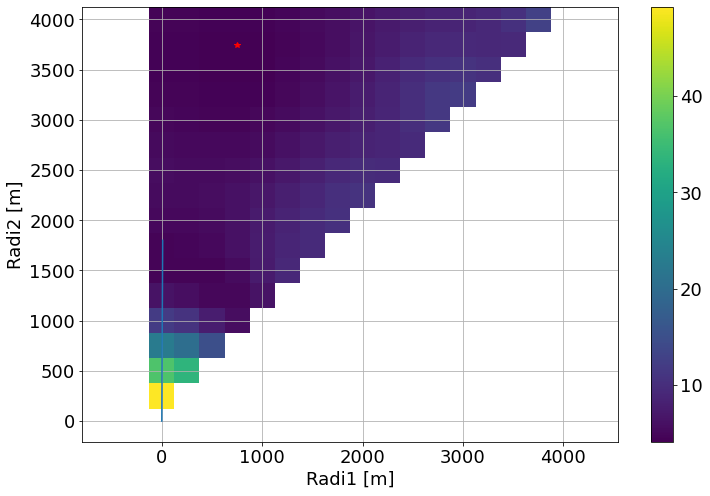

In [15]:
plt.figure(figsize=(12,8))
im=plt.pcolormesh(radi1,radi2,dist_ring_retrack.T)#,vmin=18,vmax=50)
dist_ring_retrack[np.isnan(dist_ring_retrack)]=np.inf
plt.xlabel('Radi1 [m]')
plt.ylabel('Radi2 [m]')
plt.colorbar(im)
inds=np.unravel_index(np.argmin(dist_ring_retrack, axis=None), dist_ring_retrack.shape)
print(np.min(dist_ring_retrack.T))
print(inds)
x=np.arange(0,2000,200)

_=plt.plot(x)
_=plt.plot(radi1[inds[0]],radi2[inds[1]],'*r')
_=plt.grid(True)
_=plt.axis('equal')
print('radi1 = ',radi1[inds[0]],' - radi2 = ',radi2[inds[1]])

In [5]:
def simple_retracking_process_v1(wfm,edges,nHs=251,alti_sat=519000,dx=10,offset=10,index_calc=None,wfm_ref=None,Hsm_ref=None,ispolyfit=0):
    if (type(wfm_ref)==type(None)) | (type(Hsm_ref)==type(None)):
        if (type(wfm_ref)==type(None)) ^ (type(Hsm_ref)==type(None)):
            print("optional inputs 'wfm_ref' and 'Hsm_ref' are paired inputs i.e. in order to be applied they should be given together")
            print("As this is not the case here : the basic waveform database is computed")
        wfm_ref, Hsm_ref, edges = generate_wvform_database(len(edges),nHs,edges_max=edges[-1],offset=offset)

    dr = edges[1]-edges[0]
    Apix = np.pi*2*alti_sat*dr / (dx**2) # The area of a ring, in terms of pixels 
    range_vec = 0.5*(edges[1:]+edges[:-1])

    imax=np.argmax(wfm)
    wfmmax = wfm[imax]
    wfmmaxmean = np.mean(wfm[-len(wfm)//4:])

    imin=np.max((np.argmin(np.where(wfm>0,wfm,np.inf)),1))
    imid=np.argmin(abs(range_vec-10)) # index associated with mid value (=epoch)

    # select point where the signal starts receiving energy (for low Hs ... )
    ind_min=np.argmin(np.where(wfm_ref>0,wfm_ref,np.inf),axis=1)
    imin1=np.argmin(np.where(wfm>0,wfm,np.inf))
    ind_select = np.argmax(np.where(ind_min<=imin1,ind_min,0))
#     print('Hs new method = ',Hsm_ref[ind_select],' ind select = ',ind_select)
    
    # --- 0 : upper part is calibrated with the mean of asymptotic part
    #        + Dist calculated up to val max of waveform
    dist0=np.sum((np.mean(wfm[-100:])*wfm_ref[:,:imax+1]-wfm[:imax+1])**2,axis=1)
    # --- 1 : upper part is calibrated with the max value of waveform
    #        + Dist calculated up to epoch
    dist1=np.sum((wfm[imax]*wfm_ref[:,0:imid+1]-wfm[0:imid+1])**2,axis=1)
    # --- 2 : upper part is calibrated with the area (in terms of pixel) of a ring
    #        + Dist calculated on the slope part (from wvf > 0 and <max )
    dist2=np.sum((Apix*wfm_ref[:,imin-1:imax+1]-wfm[imin-1:imax+1])**2,axis=1)
    # --- 3 : upper part is calibrated with the area (in terms of pixel) of a ring
    #        + Dist calculated on the entire wfm
    dist3=np.sum((Apix*wfm_ref-wfm)**2,axis=1)

    ind0 = np.argmin(dist0)
    ind1 = np.argmin(dist1)
    ind2 = np.argmin(dist2)
    ind3 = np.argmin(dist3)
    
    Hs0 = Hsm_ref[ind0]
    Hs1 = Hsm_ref[ind1]
    Hs2 = Hsm_ref[ind2]
    Hs3 = Hsm_ref[ind3]
    HsLow = Hsm_ref[ind_select]
    
    return Hs0,Hs1,Hs2,Hs3,HsLow

In [6]:
## -- Investigating new stuff ---------------------------------------
def fly_over_track(X,Y,S1,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,radi,radi1=3000,alti_sat=519000):
    ny_mid = len(np.unique(Y))//2
    Xalt = np.zeros((nsamp,1))
    Hs0 = np.zeros((nsamp,1))
    Hs1 = np.zeros((nsamp,1))
    Hs2 = np.zeros((nsamp,1))
    Hs3 = np.zeros((nsamp,1))
    HsLow = np.zeros((nsamp,1))
#     Hs_retrack = np.zeros((nsamp,1))
#     Hs_retrack2 = np.zeros((nsamp,1))
    Hs_std_tot = np.zeros((nsamp,1))
    Hs_std_1 = np.zeros((nsamp,1))
#     Hs_std2 = np.zeros((nsamp,1))
    waveforms=np.zeros((nsamp,len(edges_ref)-1))

    for isamp in range(nsamp):
#         clear_output(wait=True)
#         print(isamp)
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        Xa , Ya = np.meshgrid(X - X[ialt], Y - Y[ny_mid])
#         surf=S1_Gaussian[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-S1)**2)-alti_sat+10
        lim = np.sqrt(radi**2+alti_sat**2) - alti_sat +10
        lim2 = np.sqrt(radi1**2+alti_sat**2) - alti_sat +10
#         print('lim = ',lim)
        # Get the footprint for image, based on r<= lim
        indnotnan= np.where(r<=lim)
        ind11 = indnotnan[0].min()
        ind12 = indnotnan[0].max()
        ind21 = indnotnan[1].min()
        ind22 = indnotnan[1].max()
        
        r_footprint = r[ind11:ind12,ind21:ind22]#_lon_above[0],ind_lon_above[1]]
        Xa_footprint = np.zeros(r_footprint.shape)
        Xa_footprint[:,:] = Xa[ind11:ind12,ind21:ind22]
        Ya_footprint = np.zeros(r_footprint.shape)
        Ya_footprint[:,:] = Ya[ind11:ind12,ind21:ind22]
        S1_footprint = np.zeros(r_footprint.shape)
        S1_footprint[:,:] = S1[ind11:ind12,ind21:ind22]
        
        S1_footprint[r_footprint>lim]=np.nan
        r_footprint[r_footprint>lim]=np.nan
        r[r>lim]=np.nan
        if isamp == 370:
            plt.figure(figsize=(20,15))
            plt.pcolormesh(Xa_footprint,Ya_footprint,r_footprint)
            ths= np.linspace(0,2*np.pi,50)
            plt.plot(radi*np.cos(ths),radi*np.sin(ths),'-r')

        counts,_=np.histogram(r_footprint,bins=edges_ref)
#         Hs_retrack[isamp] = simple_retracking_process_v1(counts,edges_ref,wfm_ref=wfm_ref,Hsm_ref=Hsm_ref)
        Hs0[isamp],Hs1[isamp],Hs2[isamp],Hs3[isamp],HsLow[isamp] = simple_retracking_process_v1(counts,edges_ref,wfm_ref=wfm_ref,Hsm_ref=Hsm_ref)
        waveforms[isamp,:]=counts
        Hs_std_tot[isamp] = 4*np.nanstd(S1_footprint.flatten())#/np.sqrt(np.mean(footprint))
        Hs_std_1[isamp] = 4*np.nanstd(S1[r<=lim2].flatten())
        
    return Hs_std_tot,Hs_std_1,Hs0,Hs1,Hs2,Hs3,HsLow,Xalt,waveforms

In [7]:
def process_1surface(i,Z1,kX,kY):
#     random.seed(i)
#     np.random.default_rng(i)
    S1,X,Y= surface_from_Z1kxky(Z1,kX,kY,i)
    # plt.figure(figsize=(18,6))
    # im=plt.pcolormesh(X,Y,S1,cmap='seismic',norm = mcolors.Normalize(vmin=S1.min(), vmax=S1.max()))
    # plt.colorbar(im,label='$\zeta$ [m]')
    # _=plt.xlabel('X [m]')
    # _=plt.ylabel('Y [m]')
    # _=plt.title('Surface from spectrum')

    freq_satsampl=40 # freq for waveforms
    v_sat=7000 # satellite v
    alti_sat=519000 # altitude of satellite CFOSAT
    radi = 8000
    isplot_steps=0
    # --- edges for range windows ------------
    dr = 0.375
    edges_max = 70

    nHs=251
    Hs_max = 25

    wfm_ref, Hsm_ref, edges_ref = generate_wvform_database(dr,nHs,edges_max=edges_max,Hs_max=Hs_max,offset=10)

    Apix = np.pi*2*alti_sat*dr / (dx**2)

    # --- Norms et scalar map for plots ---------------------
    normG = mcolors.Normalize(vmin=S1.min(), vmax=S1.max())
    scalarMapG = cmx.ScalarMappable(norm=normG, cmap='seismic')

    nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
    di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
    nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples
    
    Hs_std_tot,Hs_std_1,Hs0,Hs1,Hs2,Hs3,HsLow,Xalt,waveforms = fly_over_track(X,Y,S1,nsamp,nxa,di,wfm_ref,Hsm_ref,edges_ref,radi,radi1=3000)

    return i,Xalt,Hs_std_tot,Hs_std_1,Hs0,Hs1,Hs2,Hs3,HsLow

In [3]:
print(mp.cpu_count())
pool = mp.Pool(mp.cpu_count()-1)

results = []

results = pool.starmap_async(process_investigateR_1surface, [(i,Z1,kX,kY) for i in range(3)]).get()
# # where process_for_1_station is defined :
# # def process_for_1_station(i,stat,PATH,pathimage):
# #     blabla
# #     return whatever
pool.close()

# # i,Xalt,Hs_std_tot,Hs_std_1,Hs0,Hs1,Hs2,Hs3,HsLow

# r_Hs_histo = [result[1] for result in results]
# r_year = [result[2] for result in results]

12
shapes : Hs_std_disk =  (50, 3)  - Hs_std_ring =  (50, 3, 4)  - Hs_retrack =  (50, 1)
shapes : Hs_std_disk =  (50, 3)  - Hs_std_ring =  (50, 3, 4)  - Hs_retrack =  (50, 1)
shapes : Hs_std_disk =  (50, 3)  - Hs_std_ring =  (50, 3, 4)  - Hs_retrack =  (50, 1)


In [5]:
ds=xr.Dataset(data_vars=dict(dist_disk_retrack=(["n","x2"],np.squeeze([result[1] for result in results])),
            dist_ring_retrack=(["n","x1","x2"],np.squeeze([result[2] for result in results])),
            Hs_retrack=(["n","nsamp"],np.squeeze([result[7] for result in results])),
            Hs_std_ring=(["n","nsamp","x2","x1"],np.squeeze([result[6] for result in results])),
            Hs_std_disk=(["n","nsamp","x2"],np.squeeze([result[5] for result in results])),
            ),
            coords=dict(radi1=(["x1"],np.squeeze(results[0][3])),
            radi2=(["x2"],np.squeeze(results[0][4])),
            Nb_rand=(["n"],np.squeeze([result[0] for result in results])),
            Hs=Hs,
            T0=T0,
            sk_k=sk_k,
            ),
            )

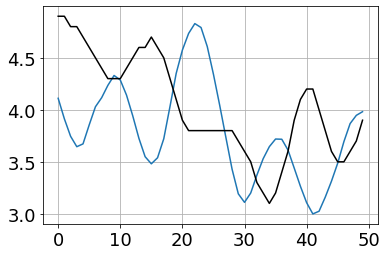

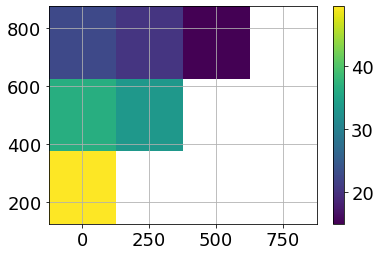

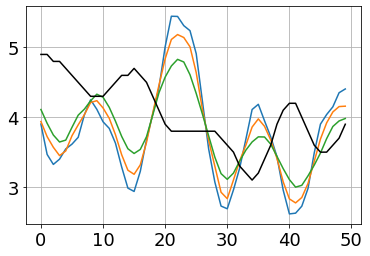

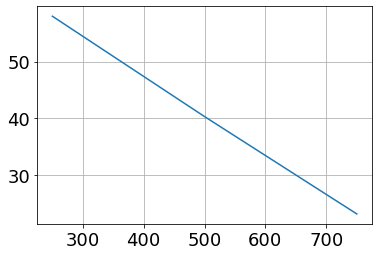

In [12]:
# ds.dist_ring_retrack.argmin(dim=['x1','x2'])
# display(ds.Hs_std_disk)
plt.figure()
plt.plot(ds.Hs_std_ring.isel(n=0).isel(x2=-1,x1=0))
# plt.plot(Hs_std_ring)
plt.plot(ds.Hs_retrack.isel(n=0),'-k')
# plt.plot(Hs_retrack,'--r')
plt.grid(True)

plt.figure()
im=plt.pcolormesh(ds.radi1,ds.radi2,ds.dist_ring_retrack.isel(n=0).T)
plt.colorbar(im)
# plt.plot(ds.Hs_retrack.isel(n=0),'-k')
plt.grid(True)


plt.figure()
plt.plot(ds.Hs_std_disk.isel(n=0))
plt.plot(ds.Hs_retrack.isel(n=0),'-k')
plt.grid(True)

plt.figure()
plt.plot(ds.radi2,ds.dist_disk_retrack.isel(n=1))
# plt.plot(ds.Hs_retrack.isel(n=0),'-k')
plt.grid(True)

In [6]:
ds.to_netcdf('example_ds_hs_sk_k.nc')

In [ ]:
list_files = ['example_ds.nc','example_ds_hs_sk_k.nc']

ds_sk_k = xr.open_mfdataset(list_files,concat_dim="sk_k",combine="nested")

In [33]:
ds_sk_k

<xarray.Dataset>
Dimensions:            (sk_k: 2, n: 3, x1: 16, x2: 16)
Coordinates:
    radi1              (x1) int64 dask.array<chunksize=(16,), meta=np.ndarray>
    radi2              (x2) int64 dask.array<chunksize=(16,), meta=np.ndarray>
    Nb_rand            (n) int64 dask.array<chunksize=(3,), meta=np.ndarray>
    Hs                 int64 8
    T0                 int64 16
  * sk_k               (sk_k) float64 0.001 0.005
Dimensions without coordinates: n, x1, x2
Data variables:
    dist_disk_retrack  (sk_k, n, x1) float64 dask.array<chunksize=(1, 3, 16), meta=np.ndarray>
    dist_ring_retrack  (sk_k, n, x2, x1) float64 dask.array<chunksize=(1, 3, 16, 16), meta=np.ndarray>

radi1 =  [[2750 3750 3500]
 [1750 2000 3000]]
radi2 =  [[ 250  250 1000]
 [ 250  250  500]]
[[ 5714.56621295 19088.35032432 20186.02514537]
 [ 2506.30959816  9691.81036563  3634.27414218]]


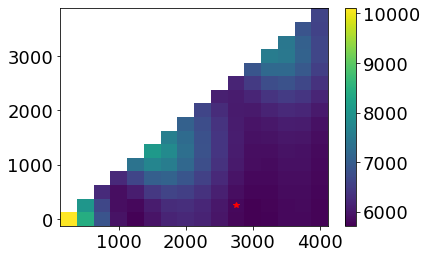

In [45]:
# print(ds_sk_k.dist_ring_retrack.argmin(dim=['x1','x2']),'\n\n')
inds=ds_sk_k.dist_ring_retrack.argmin(dim=['x1','x2'])

print('radi1 = ',ds_sk_k.radi1.isel(x1=inds['x1'].compute()).values)

print('radi2 = ',ds_sk_k.radi2.isel(x2=inds['x2'].compute()).values)

im=plt.pcolormesh(ds_sk_k.radi2,ds_sk_k.radi1,ds_sk_k.dist_ring_retrack.isel(sk_k=0,n=0))
plt.colorbar(im)
plt.plot(ds_sk_k.radi1.isel(x1=inds['x1'].compute().isel(sk_k=0,n=0)),
         ds_sk_k.radi2.isel(x2=inds['x2'].compute().isel(sk_k=0,n=0)),'*r')
# print('\ninds["x1"]:\n',inds['x1'].values)
print(ds_sk_k.dist_ring_retrack.min(dim=['x1','x2']).values)
# print('radi1 = ',ds_sk_k.isel(inds))
# print(' - radi2 = ',ds_sk_k.radi1.isel(x2=inds['x2']))

# print('\ninds[0]:\n',inds[0])
# ds_sk_k.radi1array.isel(array.argmin(dim=["x", "z"]))
# inds=np.unravel_index(np.argmin(dist_ring_retrack, axis=None), dist_ring_retrack.shape)

In [18]:

# np.squeeze([result[7] for result in results])),
Xalt_i = np.unique(np.squeeze([result[6] for result in results]))
dsHs_4_T0_16=xr.Dataset(data_vars=dict(Hs_surfStd_0=(["n","x"],np.squeeze([result[2] for result in results])),
                             Hs_surfStd_1=(["n","x"],np.squeeze([result[3] for result in results])),
                             Hs0_i=(["n","x"],np.squeeze([result[4] for result in results])),
                             Hs1_i=(["n","x"],np.squeeze([result[5] for result in results])),
                             Hs2_i=(["n","x"],np.squeeze([result[6] for result in results])),
                             Hs3_i=(["n","x"],np.squeeze([result[7] for result in results])),
                             HsLow_i=(["n","x"],np.squeeze([result[8] for result in results])),
                            ),
              coords=dict(X_alti=(["x"],np.squeeze(results[0][1])),
                          Nb_rand=(["n"],np.squeeze([result[0] for result in results])),
                         ),
             )
dsHs_4_T0_16

<xarray.Dataset>
Dimensions:       (n: 50, x: 49)
Coordinates:
    X_alti        (x) float64 8e+03 8.17e+03 8.34e+03 ... 1.599e+04 1.616e+04
    Nb_rand       (n) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: n, x
Data variables:
    Hs_surfStd_0  (n, x) float64 4.381 4.376 4.37 4.36 ... 3.837 3.841 3.85
    Hs_surfStd_1  (n, x) float64 4.68 4.675 4.664 4.624 ... 3.784 3.765 3.763
    Hs0_i         (n, x) float64 4.9 4.9 4.8 4.8 4.7 4.5 ... 5.6 5.7 5.7 5.5 5.3
    Hs1_i         (n, x) float64 4.5 4.3 4.6 4.6 4.6 4.3 ... 4.8 5.0 5.0 4.9 4.8
    Hs2_i         (n, x) float64 4.9 4.9 4.9 4.9 4.7 4.6 ... 5.6 5.8 5.8 5.6 5.4
    Hs3_i         (n, x) float64 4.9 4.9 4.8 4.8 4.7 4.6 ... 5.6 5.7 5.6 5.5 5.3
    HsLow_i       (n, x) float64 1.0 0.8 0.8 0.6 0.8 1.0 ... 1.0 0.8 0.8 0.8 1.0

In [9]:
dsHS_4_T0_14 = ds.copy(deep=True) 

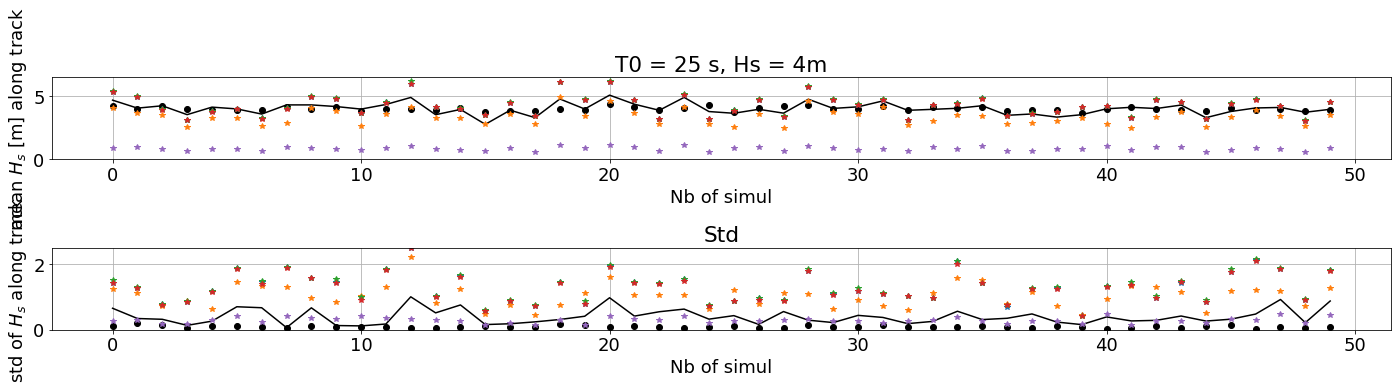

In [10]:
mpl.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})
fig,axs=plt.subplots(2,1,figsize=(20,5))#,sharey=True,sharex=True)

_=axs[0].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_0.mean(dim='x'),'ok')
_=axs[0].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_1.mean(dim='x'),'-k')
_=axs[0].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs0_i.mean(dim='x'),'*')
_=axs[0].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs1_i.mean(dim='x'),'*')
_=axs[0].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs2_i.mean(dim='x'),'*')
_=axs[0].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs3_i.mean(dim='x'),'*')
_=axs[0].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.HsLow_i.mean(dim='x'),'*')
_=axs[0].grid(True)
_=axs[0].set_ylim((0, 6.5))
_=axs[0].set_xlabel('Nb of simul')
_=axs[0].set_ylabel('mean $H_s$ [m] along track')
_=axs[0].set_title('T0 = 25 s, Hs = 4m')


_=axs[1].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_0.std(dim='x'),'ok')
_=axs[1].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_1.std(dim='x'),'-k')
_=axs[1].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs0_i.std(dim='x'),'*')
_=axs[1].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs1_i.std(dim='x'),'*')
_=axs[1].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs2_i.std(dim='x'),'*')
_=axs[1].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs3_i.std(dim='x'),'*')
_=axs[1].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.HsLow_i.std(dim='x'),'*')
_=axs[1].grid(True)
_=axs[1].set_ylim((0, 2.5))
_=axs[1].set_xlabel('Nb of simul')
_=axs[1].set_ylabel('std of $H_s$ along track')
_=axs[1].set_title('Std')
_=plt.tight_layout()

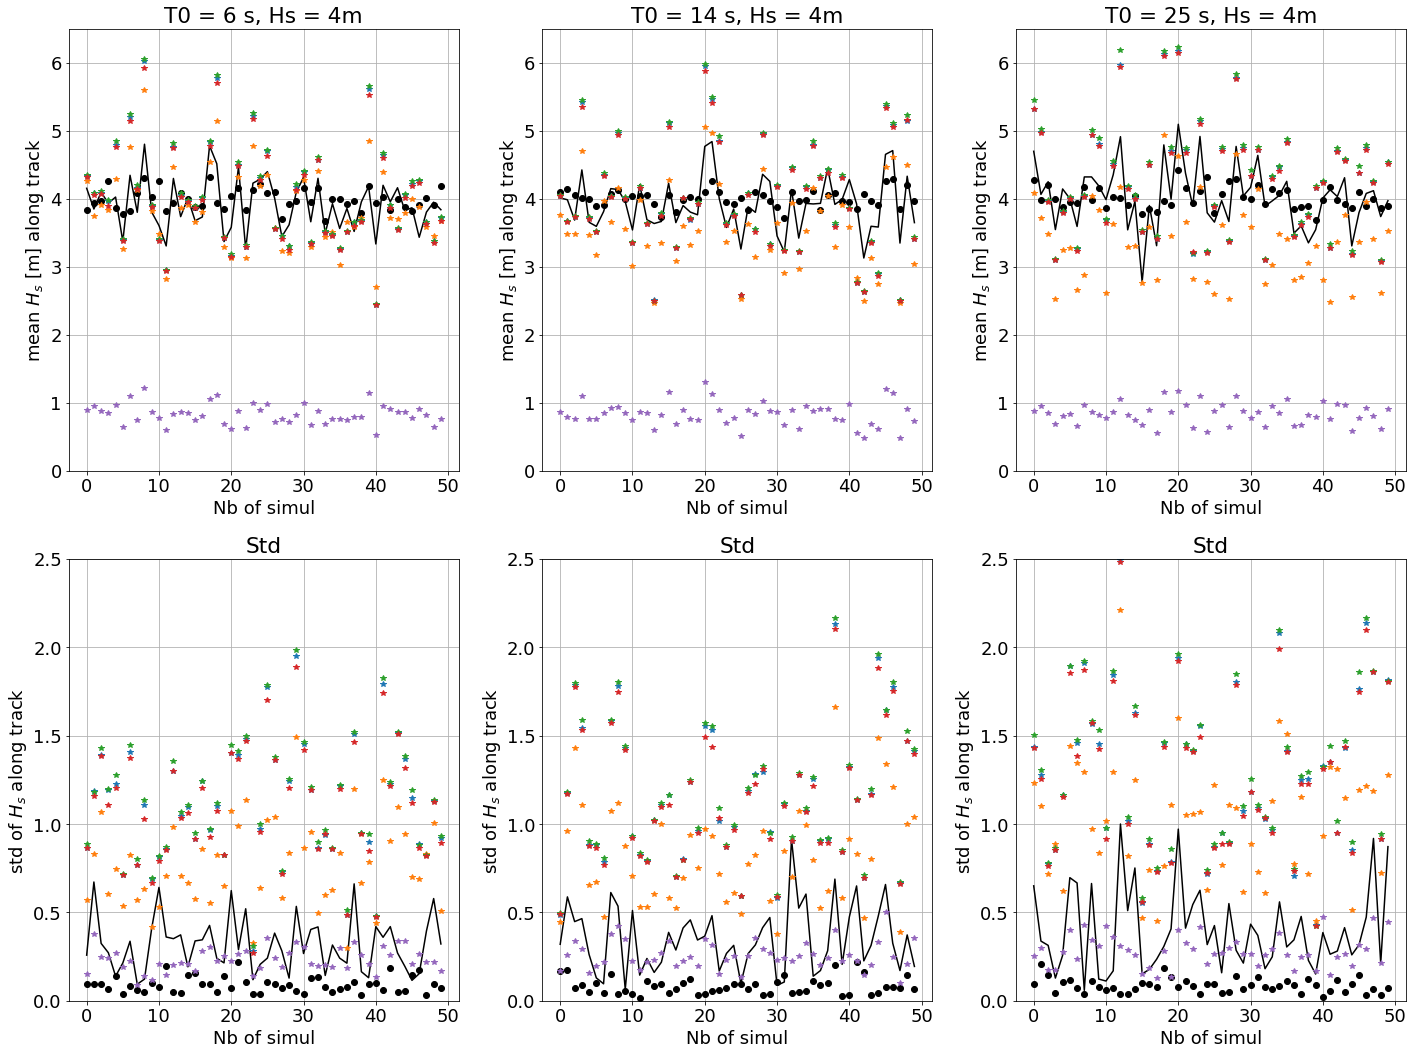

In [20]:
mpl.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})
fig,axs=plt.subplots(2,3,figsize=(20,15))#,sharey=True,sharex=True)

_=axs[0][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs_surfStd_0.mean(dim='x'),'ok')
_=axs[0][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs_surfStd_1.mean(dim='x'),'-k')
_=axs[0][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs0_i.mean(dim='x'),'*')
_=axs[0][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs1_i.mean(dim='x'),'*')
_=axs[0][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs2_i.mean(dim='x'),'*')
_=axs[0][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs3_i.mean(dim='x'),'*')
_=axs[0][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.HsLow_i.mean(dim='x'),'*')
_=axs[0][0].grid(True)
_=axs[0][0].set_ylim((0, 6.5))
_=axs[0][0].set_xlabel('Nb of simul')
_=axs[0][0].set_ylabel('mean $H_s$ [m] along track')
_=axs[0][0].set_title('T0 = 6 s, Hs = 4m')


_=axs[1][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs_surfStd_0.std(dim='x'),'ok')
_=axs[1][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs_surfStd_1.std(dim='x'),'-k')
_=axs[1][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs0_i.std(dim='x'),'*')
_=axs[1][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs1_i.std(dim='x'),'*')
_=axs[1][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs2_i.std(dim='x'),'*')
_=axs[1][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.Hs3_i.std(dim='x'),'*')
_=axs[1][0].plot(dsHs_4_T0_6.Nb_rand,dsHs_4_T0_6.HsLow_i.std(dim='x'),'*')
_=axs[1][0].grid(True)
_=axs[1][0].set_ylim((0, 2.5))
_=axs[1][0].set_xlabel('Nb of simul')
_=axs[1][0].set_ylabel('std of $H_s$ along track')
_=axs[1][0].set_title('Std')

_=axs[0][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs_surfStd_0.mean(dim='x'),'ok')
_=axs[0][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs_surfStd_1.mean(dim='x'),'-k')
_=axs[0][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs0_i.mean(dim='x'),'*')
_=axs[0][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs1_i.mean(dim='x'),'*')
_=axs[0][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs2_i.mean(dim='x'),'*')
_=axs[0][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs3_i.mean(dim='x'),'*')
_=axs[0][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.HsLow_i.mean(dim='x'),'*')
_=axs[0][1].grid(True)
_=axs[0][1].set_ylim((0, 6.5))
_=axs[0][1].set_xlabel('Nb of simul')
_=axs[0][1].set_ylabel('mean $H_s$ [m] along track')
_=axs[0][1].set_title('T0 = 14 s, Hs = 4m')

_=axs[1][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs_surfStd_0.std(dim='x'),'ok')
_=axs[1][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs_surfStd_1.std(dim='x'),'-k')
_=axs[1][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs0_i.std(dim='x'),'*')
_=axs[1][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs1_i.std(dim='x'),'*')
_=axs[1][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs2_i.std(dim='x'),'*')
_=axs[1][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.Hs3_i.std(dim='x'),'*')
_=axs[1][1].plot(dsHs_4_T0_16.Nb_rand,dsHs_4_T0_16.HsLow_i.std(dim='x'),'*')
_=axs[1][1].grid(True)
_=axs[1][1].set_ylim((0, 2.5))
_=axs[1][1].set_xlabel('Nb of simul')
_=axs[1][1].set_ylabel('std of $H_s$ along track')
_=axs[1][1].set_title('Std')


_=axs[0][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_0.mean(dim='x'),'ok')
_=axs[0][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_1.mean(dim='x'),'-k')
_=axs[0][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs0_i.mean(dim='x'),'*')
_=axs[0][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs1_i.mean(dim='x'),'*')
_=axs[0][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs2_i.mean(dim='x'),'*')
_=axs[0][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs3_i.mean(dim='x'),'*')
_=axs[0][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.HsLow_i.mean(dim='x'),'*')
_=axs[0][2].grid(True)
_=axs[0][2].set_ylim((0, 6.5))
_=axs[0][2].set_xlabel('Nb of simul')
_=axs[0][2].set_ylabel('mean $H_s$ [m] along track')
_=axs[0][2].set_title('T0 = 25 s, Hs = 4m')


_=axs[1][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_0.std(dim='x'),'ok')
_=axs[1][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs_surfStd_1.std(dim='x'),'-k')
_=axs[1][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs0_i.std(dim='x'),'*')
_=axs[1][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs1_i.std(dim='x'),'*')
_=axs[1][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs2_i.std(dim='x'),'*')
_=axs[1][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.Hs3_i.std(dim='x'),'*')
_=axs[1][2].plot(dsHs_4_T0_25.Nb_rand,dsHs_4_T0_25.HsLow_i.std(dim='x'),'*')
_=axs[1][2].grid(True)
_=axs[1][2].set_ylim((0, 2.5))
_=axs[1][2].set_xlabel('Nb of simul')
_=axs[1][2].set_ylabel('std of $H_s$ along track')
_=axs[1][2].set_title('Std')
_=plt.tight_layout()


48
lim =  71.65337077248842
Hs new method =  0.6000000000000001  ind select =  6


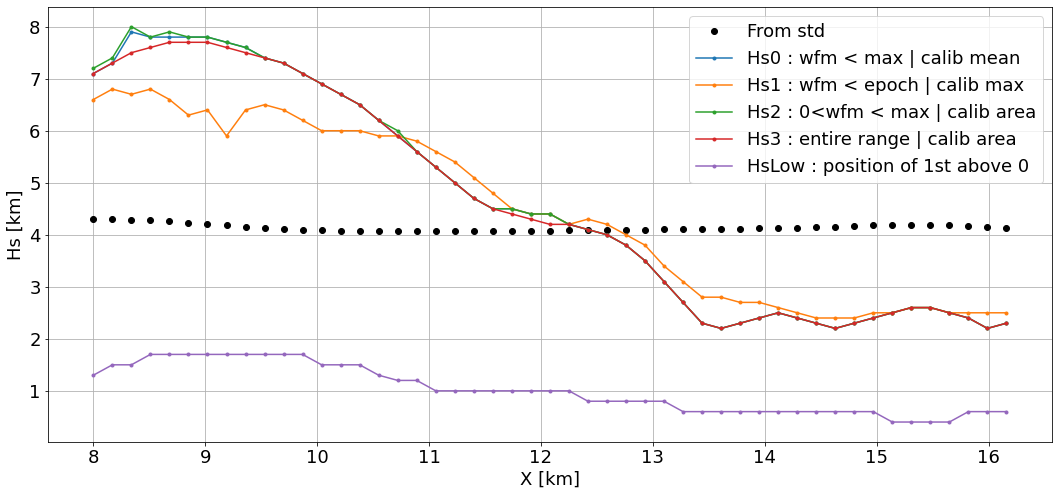

In [188]:
plt.figure(figsize=(18,8))
plt.plot(Xalt/1000,Hs_std,'ok',label='From std')
plt.plot(Xalt/1000,Hs0,'.-',label='Hs0 : wfm < max | calib mean')
plt.plot(Xalt/1000,Hs1,'.-',label='Hs1 : wfm < epoch | calib max')
plt.plot(Xalt/1000,Hs2,'.-',label='Hs2 : 0<wfm < max | calib area')
plt.plot(Xalt/1000,Hs3,'.-',label='Hs3 : entire range | calib area')
plt.plot(Xalt/1000,HsLow,'.-',label='HsLow : position of 1st above 0')
plt.xlabel('X [km]')
plt.ylabel('Hs [km]')
plt.legend()
plt.grid(True)

In [155]:
print('nsamp = ',nsamp)

nsamp =  2


In [157]:
print(nx-2*nxa)
print(nx)
print(nxa)

848
2448
800


117
22
x =  10.3125  - f(x) =  7521.0
indice for range ~ 10 :  26  associated range =  9.9375
Hs new method =  0.8  ind select =  8
dist0 => Hs =  3.1
dist1 => Hs =  3.5
dist2 => Hs =  3.1
dist3 => Hs =  3.8000000000000003


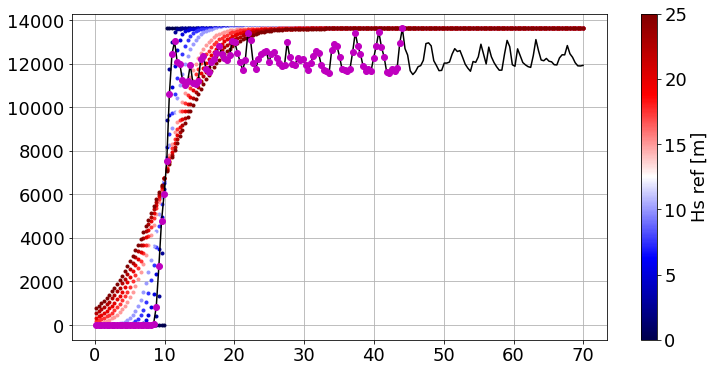

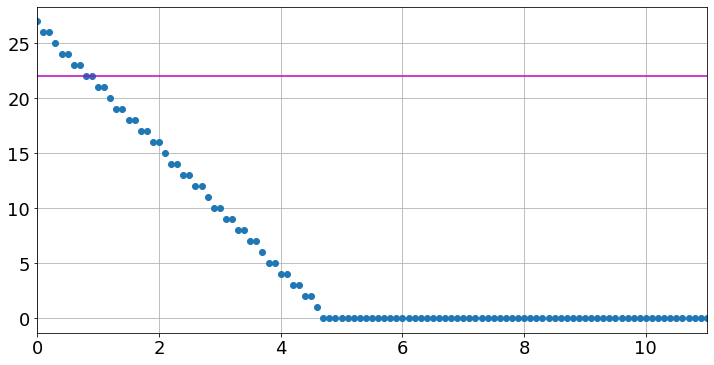

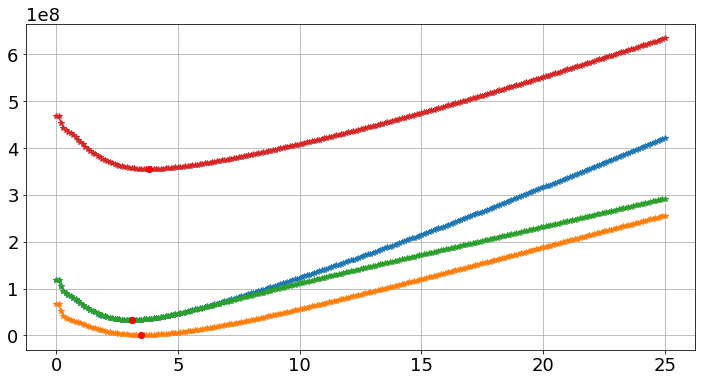

In [164]:
wfm = waveforms[70,:]
range_vec = 0.5*(edges_ref[1:]+edges_ref[:-1])
imax=np.argmax(wfm)
print(imax)
imin=np.max((np.argmin(np.where(wfm>0,wfm,np.inf)),1))
print(imin)

delta_wfm = wfm[imax]-wfm[imin-1]
imid=np.argmin(abs(wfm-0.5*delta_wfm))
# p= np.poly1d(np.polyfit(range_vec[imin-1:imax+1],wfm[imin-1:imax+1],5))
print('x = ',range_vec[imid],' - f(x) = ',wfm[imid])
x=np.linspace(range_vec[imin-1],range_vec[imax],100)
imid2=np.argmin(abs(p(x)-0.5*delta_wfm))
# print('x = ', x[imid2],' - f(x) = ',p(x[imid2]))
imid=np.argmin(abs(range_vec-10))
print('indice for range ~ 10 : ',imid,' associated range = ',range_vec[imid])

colors = plt.cm.seismic(np.linspace(0,1,11))
normHsref = mcolors.Normalize(vmin=0, vmax=Hsm_ref[25*10])
scalarMapHsref = cmx.ScalarMappable(norm=normHsref, cmap='seismic')
plt.figure(figsize=(12,6))
for k in range(11):
    plt.plot(range_vec,wfm_ref[25*k,:]*wfm[imax],'.',color=colors[k])
_=plt.colorbar(scalarMapHsref,label='Hs ref [m]')
plt.plot(range_vec,wfm,'-k')
plt.plot(range_vec[:imax+1],wfm[:imax+1],'om')
# plt.xlim((0,11))
# plt.ylim((-0.5,20))
plt.grid(True)

ind_min=np.argmin(np.where(wfm_ref>0,wfm_ref,np.inf),axis=1)
imin1=np.argmin(np.where(wfm>0,wfm,np.inf))
ind_select = np.argmax(np.where(ind_min<=imin1,ind_min,0))
print('Hs new method = ',Hsm_ref[ind_select],' ind select = ',ind_select)

plt.figure(figsize=(12,6))
plt.plot(Hsm_ref,ind_min,'o')
plt.plot([Hsm_ref[0],Hsm_ref[-1]],[imin1,imin1],'-m')
plt.grid(True)
plt.xlim((0,11))


dist0=np.sum((np.mean(wfm[-100:])*wfm_ref[:,:imax+1]-wfm[:imax+1])**2,axis=1)
dist1=np.sum((wfm[imax]*wfm_ref[:,0:imid+1]-wfm[0:imid+1])**2,axis=1)
dist2=np.sum((Apix*wfm_ref[:,imin-1:imax+1]-wfm[imin-1:imax+1])**2,axis=1)
dist3=np.sum((wfm[imax]*wfm_ref-wfm)**2,axis=1)

ind0 = np.argmin(dist0)
ind1 = np.argmin(dist1)
ind2 = np.argmin(dist2)
ind3 = np.argmin(dist3)

plt.figure(figsize=(12,6))
plt.plot(Hsm_ref,dist0,'-*')
plt.plot(Hsm_ref[ind0],dist0[ind0],'or')
print('dist0 => Hs = ',Hsm_ref[ind0])
plt.plot(Hsm_ref,dist1,'-*')
plt.plot(Hsm_ref[ind1],dist1[ind1],'or')
print('dist1 => Hs = ',Hsm_ref[ind1])
plt.plot(Hsm_ref,dist2,'-*')
plt.plot(Hsm_ref[ind2],dist2[ind2],'or')
print('dist2 => Hs = ',Hsm_ref[ind2])
plt.plot(Hsm_ref,dist3,'-*')
plt.plot(Hsm_ref[ind3],dist3[ind3],'or')
print('dist3 => Hs = ',Hsm_ref[ind3])
plt.grid(True)


In [ ]:
print(X.shape)
print(Y.shape)
A=None
print(A)
print(type(A)==type(None))
print(type(Hsm_ref)==type(None))

73


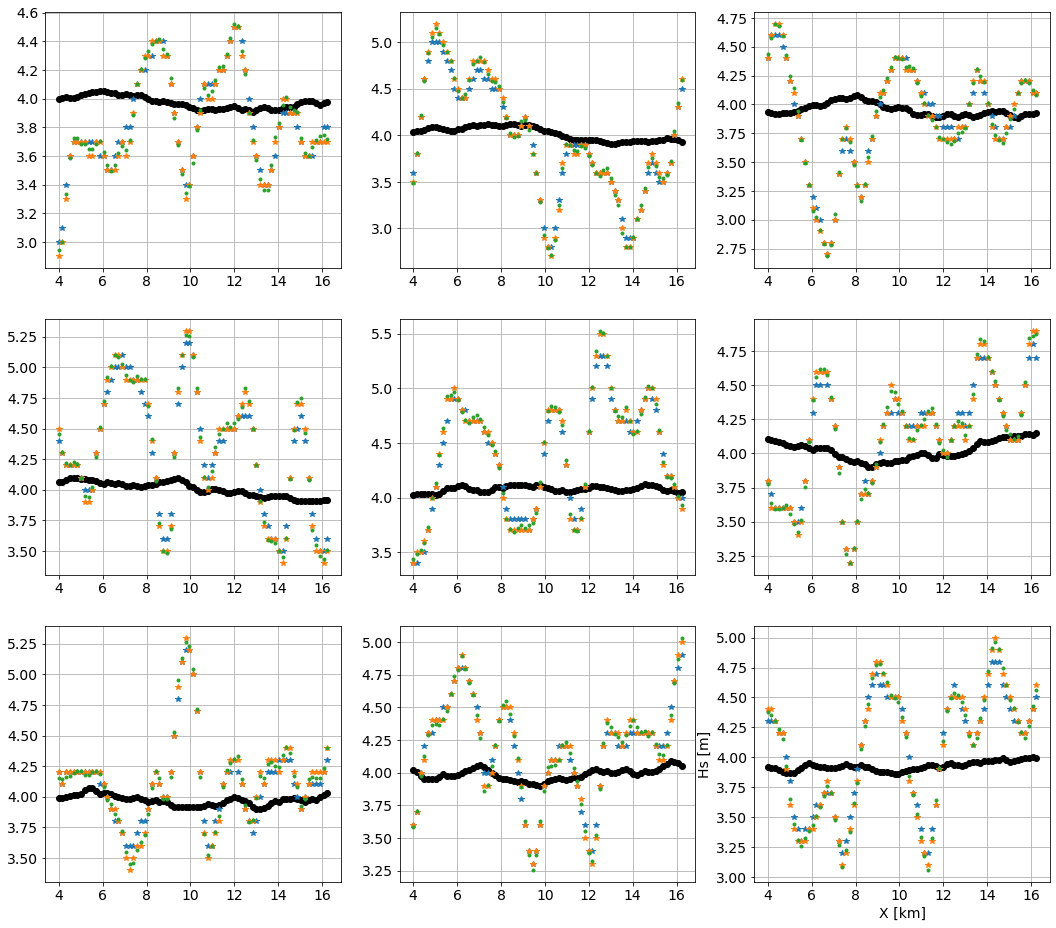

In [19]:
footprint=np.ones((2*nxa+1,2*nxa+1))
[Xa,Ya]=np.meshgrid(dx*np.arange(-nxa,nxa+1), dy*np.arange(-nxa,nxa+1))
dist_ground = (Xa**2+Ya**2)
footprint[dist_ground > radi**2]=np.nan


nbsurfk=9

# --- initialisation of Hs bases ----------------------

Hsalt=np.zeros((nsamp,nbsurfk))
Hs_retrack=np.zeros((nsamp,nbsurfk))
Hs_retrack2=np.zeros((nsamp,nbsurfk))
Hs_retrack3=np.zeros((nsamp,nbsurfk))
Xalt=np.zeros((nsamp,1))
waveforms=np.zeros((nsamp,ne-1))
wfr=np.zeros((nsamp,2))
print(nsamp)
# fig,axs = plt.subplots(10,8,figsize=(20,40))
ny_mid = (ny//2)

wfm_ref, Hsm_ref, edges = generate_wvform_database(len(edges),nHs,edges_max=edges[-1])
colors = plt.cm.seismic(np.linspace(0,1,11))
normHsref = mcolors.Normalize(vmin=0, vmax=Hsm_ref[25*10])
scalarMapHsref = cmx.ScalarMappable(norm=normHsref, cmap='seismic')

PATH = '/home/mdecarlo/PROJETS/CFOSAT_processing/ex_2/'

fig2,axs2=plt.subplots(3,3,figsize=(18,16))
for ik in range(nbsurfk):
    S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)

    for isamp in range(nsamp):
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        surf=S1_Gaussian[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-surf)**2)-alti_sat+10
        r[dist_ground > radi**2]=np.nan
        counts,_=np.histogram(r,bins=edges)
        Hs_retrack[isamp,ik],dist,Hs_retrack2[isamp,ik],Hs_retrack3[isamp,ik] = simple_retracking_process(counts,edges) 
        waveforms[isamp,:]=counts
        Hsalt[isamp,ik] = 4*np.nanstd(surf.flatten())#/np.sqrt(np.mean(footprint))
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[0,:]*Apix,'-b')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[-1,:]*Apix,'-r')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],counts,'*')
        if ik==0:
            isplot_steps = 1
        else:
            isplot_steps = 0
        isplot_steps = 0
        if isplot_steps:
            fig,axs=plt.subplots(1,3,figsize=(18,6))
            axs[0].pcolormesh(Xa,Ya,surf,cmap='seismic',norm = normG)
            _=plt.colorbar(scalarMapG,ax=axs[0],label='surface')
            axs[0].axis('equal')

#             print('R min = ',r[np.isfinite(r)].min(), ' and R max = ',r[np.isfinite(r)].max())
            normR = mcolors.Normalize(vmin=r[np.isfinite(r)].min(), vmax=r[np.isfinite(r)].max())
            scalarMapR = cmx.ScalarMappable(norm=normR, cmap='jet')
            axs[1].pcolormesh(Xa,Ya,r,cmap='jet',norm = normR)
            _=plt.colorbar(scalarMapR,ax=axs[1],label='range')
            axs[1].axis('equal')

            for k in range(11):
                axs[2].plot(edges[:-1],wfm_ref[k*25,:]*Apix,'-',color=colors[k])
            axs[2].plot(edges[:-1],counts,'ok')
            _=plt.colorbar(scalarMapHsref,ax=axs[2],label='Hs ref [m]')
            axs[2].grid(True)
            axs[2].set_ylim((-0.5,21000))
            plt.tight_layout()

            plt.savefig(PATH+'waveform_footprint_'+f'{isamp:02d}'+'.png')
            plt.close(fig)
    #     axs[isamp//8][isamp%8].plot(Hsm_ref,dist,'*')
    #     axs[isamp//8][isamp%8].pcolormesh(Xa,Ya,surf)
    
# plt.figure(figsize=(16,6))
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    plt.xlabel('X [km]')
    plt.ylabel('Hs [m]')
#     axs[ik//3,ik%3].legend()
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian_ex2.png')
# Hs_retrack25 = Hs_retrack

73


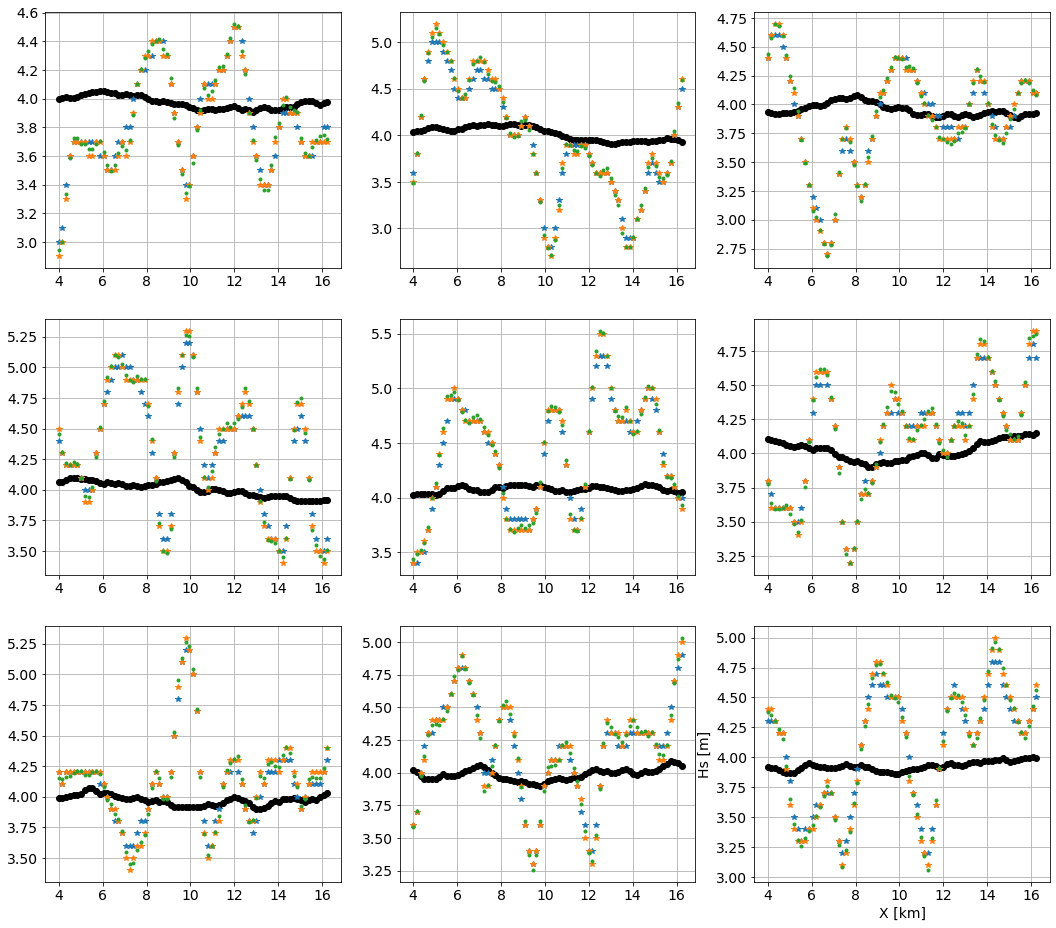

In [19]:
# OLD Version

freq_satsampl=40 # freq for waveforms
v_sat=7000 # satellite v
nsy=512
alti_sat=560000 # altitude of satellite CFOSAT

isplot_steps=0
# --- edges for range windows ------------
ne = 51
edges = np.linspace(0,20,ne)
dr = edges[1]-edges[0]
Apix = np.pi*2*alti_sat*dr / (dx**2)
# --- Hs vector --------------------------
nHs=251
Hsm = np.linspace(0,25,nHs)

normG = mcolors.Normalize(vmin=S1_Gaussian.min(), vmax=S1_Gaussian.max())
scalarMapG = cmx.ScalarMappable(norm=normG, cmap='seismic')

radi=4000   # radius of footprint
nxa=np.floor(radi/dx).astype(int) # size of radius of footprint in pixel
footprint=np.ones((2*nxa+1,2*nxa+1))
[Xa,Ya]=np.meshgrid(dx*np.arange(-nxa,nxa+1), dy*np.arange(-nxa,nxa+1))
dist_ground = (Xa**2+Ya**2)
footprint[dist_ground > radi**2]=np.nan

di=np.floor((v_sat/freq_satsampl)/dx).astype(int) # distance between footprint centers, in pixels (v_sat/freq_satsampl = dsitance in m)
nsamp=np.floor((nx-2*nxa)/di).astype(int) # Nb of samples


nbsurfk=9

# --- initialisation of Hs bases ----------------------

Hsalt=np.zeros((nsamp,nbsurfk))
Hs_retrack=np.zeros((nsamp,nbsurfk))
Hs_retrack2=np.zeros((nsamp,nbsurfk))
Hs_retrack3=np.zeros((nsamp,nbsurfk))
Xalt=np.zeros((nsamp,1))
waveforms=np.zeros((nsamp,ne-1))
wfr=np.zeros((nsamp,2))
print(nsamp)
# fig,axs = plt.subplots(10,8,figsize=(20,40))
ny_mid = (ny//2)

wfm_ref, Hsm_ref, edges = generate_wvform_database(len(edges),nHs,edges_max=edges[-1])
colors = plt.cm.seismic(np.linspace(0,1,11))
normHsref = mcolors.Normalize(vmin=0, vmax=Hsm_ref[25*10])
scalarMapHsref = cmx.ScalarMappable(norm=normHsref, cmap='seismic')

PATH = '/home/mdecarlo/PROJETS/CFOSAT_processing/ex_2/'

fig2,axs2=plt.subplots(3,3,figsize=(18,16))
for ik in range(nbsurfk):
    S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)

    for isamp in range(nsamp):
        ialt=(nxa+isamp*di).astype(int)
        Xalt[isamp] = X[ialt]
        surf=S1_Gaussian[ny_mid-nxa:ny_mid+nxa+1,ialt-nxa:ialt+nxa+1]*footprint
        # to have distance to satellite = range
        r=np.sqrt(Xa**2+Ya**2+(alti_sat-surf)**2)-alti_sat+10
        r[dist_ground > radi**2]=np.nan
        counts,_=np.histogram(r,bins=edges)
        Hs_retrack[isamp,ik],dist,Hs_retrack2[isamp,ik],Hs_retrack3[isamp,ik] = simple_retracking_process(counts,edges) 
        waveforms[isamp,:]=counts
        Hsalt[isamp,ik] = 4*np.nanstd(surf.flatten())#/np.sqrt(np.mean(footprint))
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[0,:]*Apix,'-b')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],wfm_ref[-1,:]*Apix,'-r')
    #     axs[isamp//8][isamp%8].plot(edges[:-1],counts,'*')
        if ik==0:
            isplot_steps = 1
        else:
            isplot_steps = 0
        isplot_steps = 0
        if isplot_steps:
            fig,axs=plt.subplots(1,3,figsize=(18,6))
            axs[0].pcolormesh(Xa,Ya,surf,cmap='seismic',norm = normG)
            _=plt.colorbar(scalarMapG,ax=axs[0],label='surface')
            axs[0].axis('equal')

#             print('R min = ',r[np.isfinite(r)].min(), ' and R max = ',r[np.isfinite(r)].max())
            normR = mcolors.Normalize(vmin=r[np.isfinite(r)].min(), vmax=r[np.isfinite(r)].max())
            scalarMapR = cmx.ScalarMappable(norm=normR, cmap='jet')
            axs[1].pcolormesh(Xa,Ya,r,cmap='jet',norm = normR)
            _=plt.colorbar(scalarMapR,ax=axs[1],label='range')
            axs[1].axis('equal')

            for k in range(11):
                axs[2].plot(edges[:-1],wfm_ref[k*25,:]*Apix,'-',color=colors[k])
            axs[2].plot(edges[:-1],counts,'ok')
            _=plt.colorbar(scalarMapHsref,ax=axs[2],label='Hs ref [m]')
            axs[2].grid(True)
            axs[2].set_ylim((-0.5,21000))
            plt.tight_layout()

            plt.savefig(PATH+'waveform_footprint_'+f'{isamp:02d}'+'.png')
            plt.close(fig)
    #     axs[isamp//8][isamp%8].plot(Hsm_ref,dist,'*')
    #     axs[isamp//8][isamp%8].pcolormesh(Xa,Ya,surf)
    
# plt.figure(figsize=(16,6))
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    plt.xlabel('X [km]')
    plt.ylabel('Hs [m]')
#     axs[ik//3,ik%3].legend()
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian_ex2.png')
# Hs_retrack25 = Hs_retrack

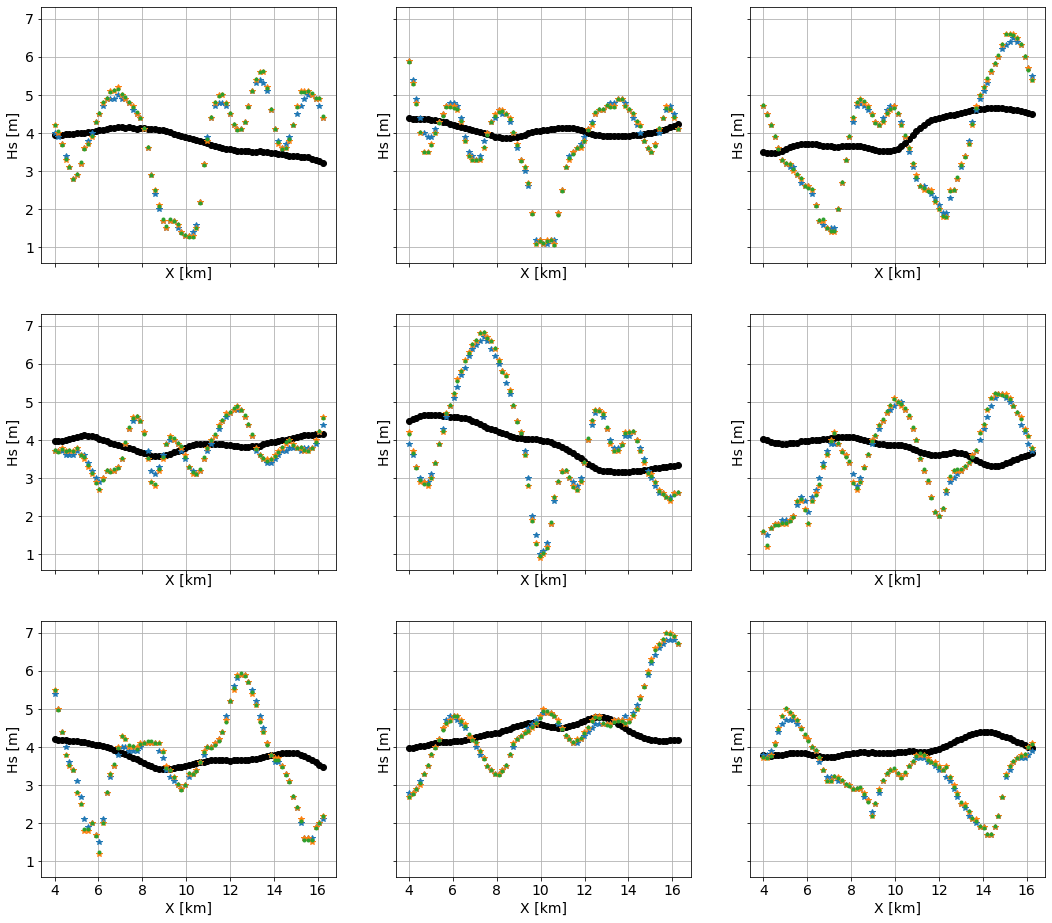

In [11]:
fig2,axs2=plt.subplots(3,3,figsize=(18,16),sharey=True,sharex=True)
for ik in range(nbsurfk):
    axs2[ik//3,ik%3].plot(Xalt/1000,Hsalt[:,ik],'ok',label='Hs from std of surf')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack[:,ik],'*',label='Hs from min dist')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack2[:,ik],'*',label='Hs from min dist 1 iter')
    axs2[ik//3,ik%3].plot(Xalt/1000,Hs_retrack3[:,ik],'.',label='Hs from min dist 1 iter + polyfit')
    axs2[ik//3,ik%3].grid(True)
    axs2[ik//3,ik%3].set_xlabel('X [km]')
    axs2[ik//3,ik%3].set_ylabel('Hs [m]')
    
plt.savefig(PATH+'Hsalt_vs_retrack_various_SGaussian2.png')

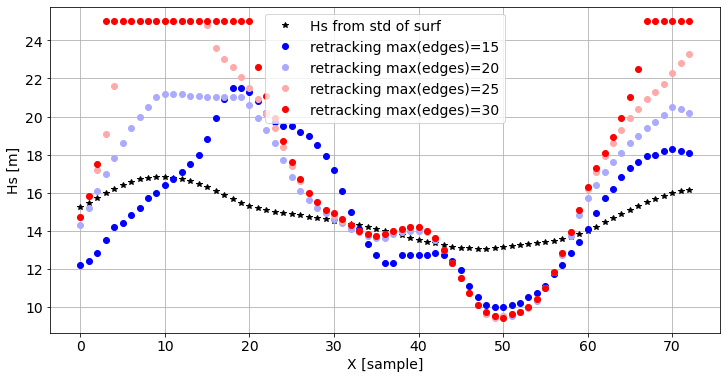

In [96]:
plt.figure(figsize=(12,6))
plt.plot(Hsalt,'*k',label='Hs from std of surf ')
colors = plt.cm.bwr(np.linspace(0,1,4))
plt.plot(Hs_retrack15,'o',color=colors[0],label='retracking max(edges)=15')
plt.plot(Hs_retrack20,'o',color=colors[1],label='retracking max(edges)=20')
plt.plot(Hs_retrack25,'o',color=colors[2],label='retracking max(edges)=25')
plt.plot(Hs_retrack30,'o',color=colors[3],label='retracking max(edges)=30')
plt.grid(True)
plt.xlabel('X [sample]')
plt.ylabel('Hs [m]')
plt.legend()
plt.savefig(PATH+'Hsalt_vs_various_retrack.png')


157549.7991537616
0.0


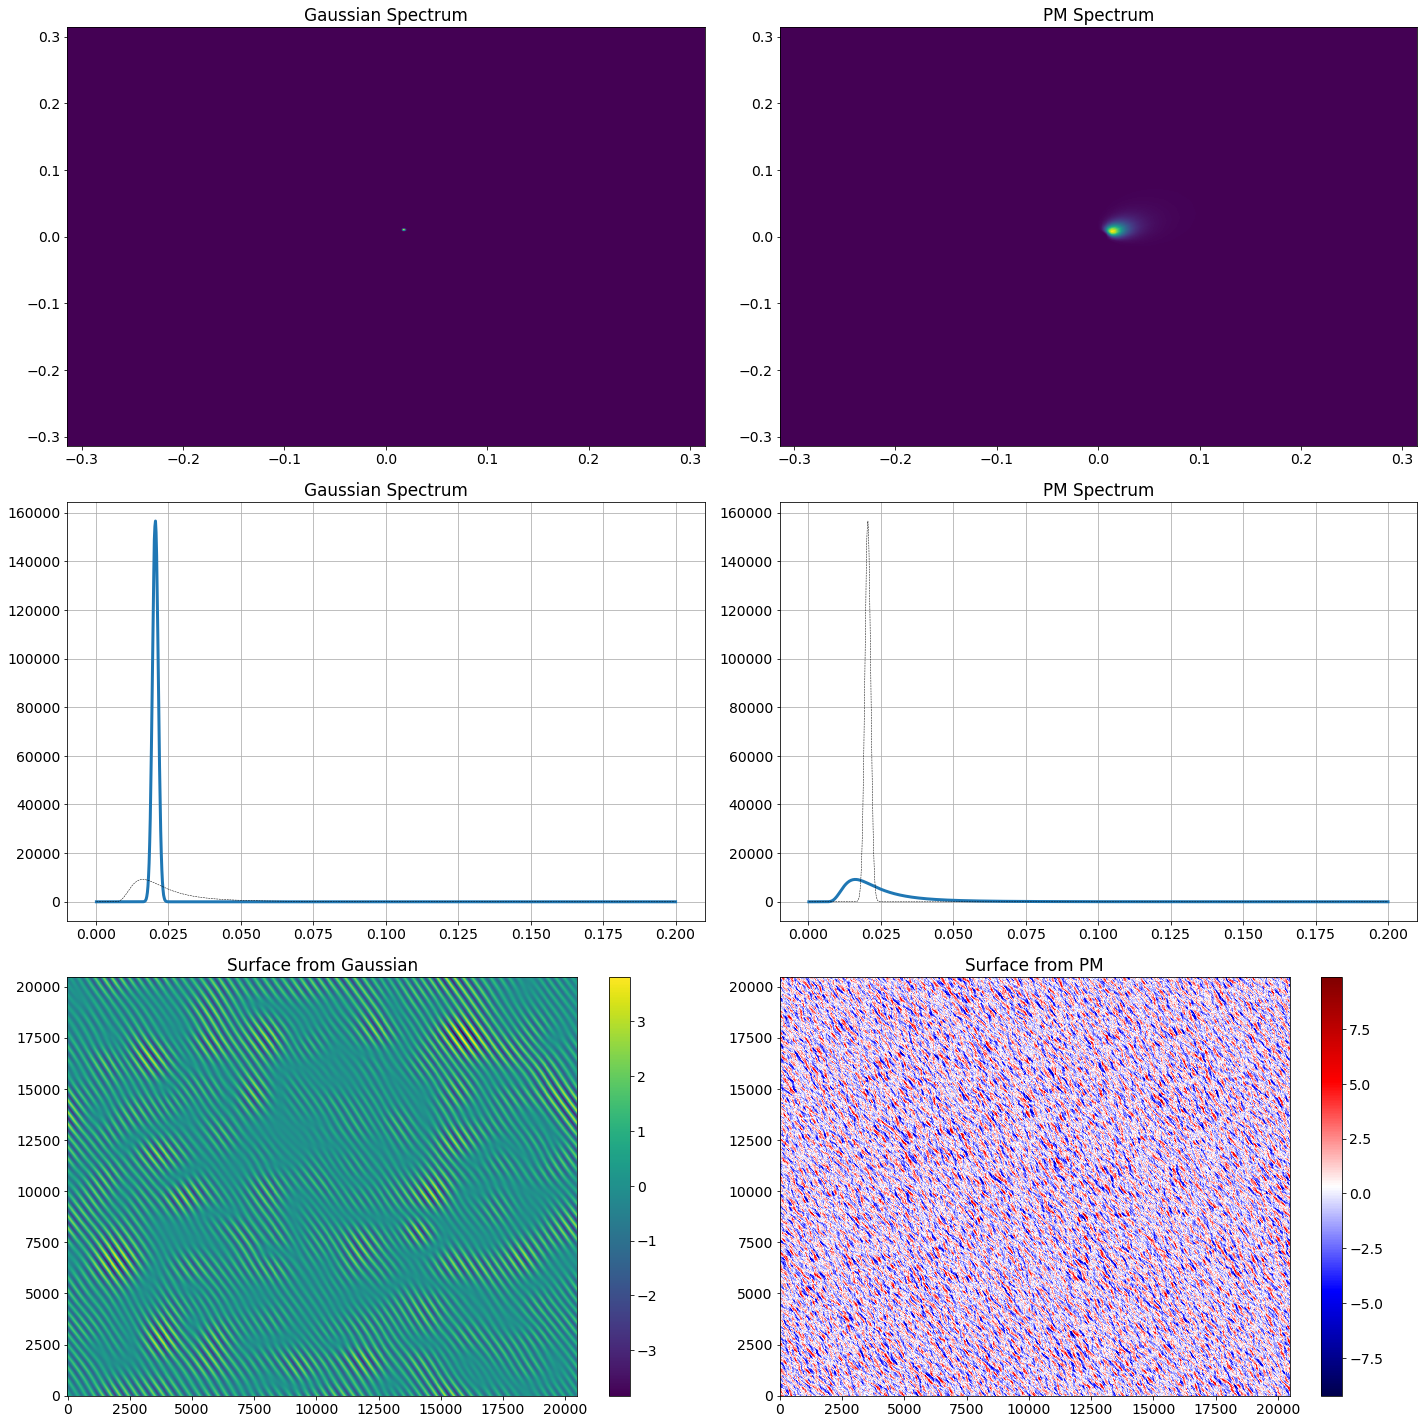

In [3]:
# OLD VERSION
# X, Y : grid of wavenumbers = 2 * pi /wavelength
# steps : dkx and dky, with nx and ny values. dkx = 2*pi/(dx*nx)
# x, y : grid of real x,y : nx values with a dx step. 
noise= 0
## ---  physical surface definition
# number of x values
nx = 2048
ny = 2048
dx = 10 # [m]
dy = 10 # [m]

# X = np.arange(0,nx*dx,dx) # from 0 to (nx-1)*dx with a dx step
# Y = np.arange(0,ny*dy,dy) # from 0 to (ny-1)*dy with a dy step
## --- equivalent wavenumber space ----
dkx = 2*np.pi/(dx*nx)
dky = 2*np.pi/(dy*ny)

kX0 = dkx*np.arange(-nx//2+1,nx//2+1)
kY0 = dky*np.arange(-ny//2+1,ny//2+1)
kX,kY = np.meshgrid(kX0, kY0)

## --- read_spectra
theta_m=30
D=1000
T0=14
Hs = 15

## --- 1. Gaussian -------
sk_theta = 0.001
sk_k = 0.001
Z1_Gaussian0,kX,kY=define_Gaussian_spectrum_kxky(kX,kY,T0,theta_m*np.pi/180,sk_theta,sk_k,D=D)
# Z1_Gaussian =(Hs/4)**2*Z1_Gaussian0
Z1_Gaussian =Z1_Gaussian0
sumZ1=4*np.sqrt(sum(Z1_Gaussian.flatten()*dkx*dky)) 
print('Hs for Gaussian : ',sumZ1)

## --- 2. Pierson - Moskowitz -----------------------------
nk=1001
nth=36
k=np.linspace(0.0002,0.2,nk)
thetas=np.linspace(0,360*(nth-1)/nth,nth)*np.pi/180.

Ekth,k,th = define_spectrum_PM_cos2n(k,thetas,T0,theta_m*np.pi/180.,D=D)
Ekxky, kx, ky = spectrum_to_kxky(1,Ekth,k,thetas,D=D)

Z1_PM=spi.griddata((kx.flatten(),ky.flatten()),Ekxky.flatten(),(kX,kY),fill_value=0)
sumZ1=4*np.sqrt(sum(Z1_PM.flatten()*dkx*dky)) 
print('Hs for Pierson Moskowitz : ',sumZ1)

## ----- Extract k spectrum in theta_m direction ----------
kx_vec = k*np.cos(theta_m*np.pi/180)
ky_vec = k*np.sin(theta_m*np.pi/180)

Z1k_PM = spi.griddata((kx.flatten(),ky.flatten()),Ekxky.flatten(),(kx_vec,ky_vec),fill_value=0)

f = spi.interp2d(kX0,kY0,Z1_Gaussian)
Z1k_Gaussian = np.diag(f(kx_vec,ky_vec))

## ----- Obtain surface ----------------------------------
S1_Gaussian,X,Y= surface_from_Z1kxky(Z1_Gaussian,kX,kY)
S1_PM,X,Y= surface_from_Z1kxky(Z1_PM,kX,kY)


## ----- Draw figure -------------------------------------
fig,axs=plt.subplots(3,2,figsize=(20,20))#,sharey=True,sharex=True)
print(Z1_Gaussian.max())
print(Z1_Gaussian.min())
axs[0][0].pcolormesh(kX,kY,Z1_Gaussian)
axs[0][0].set_title('Gaussian Spectrum')

axs[0][1].pcolormesh(kX,kY,Z1_PM)
axs[0][1].set_title('PM Spectrum')

axs[1][0].plot(k,Z1k_Gaussian,linewidth=3)
axs[1][0].plot(k,Z1k_PM,'--k',linewidth=0.5)
axs[1][0].grid(True)
axs[1][0].set_title('Gaussian Spectrum')

axs[1][1].plot(k,Z1k_PM,linewidth=3)
axs[1][1].plot(k,Z1k_Gaussian,'--k',linewidth=0.5)
axs[1][1].grid(True)
axs[1][1].set_title('PM Spectrum')

im=axs[2][0].pcolormesh(X,Y,S1_Gaussian,cmap='viridis',norm = mcolors.Normalize(vmin=S1_Gaussian.min(), vmax=S1_Gaussian.max()))
axs[2][0].set_title('Surface from Gaussian')
_=plt.colorbar(im,ax=axs[2][0])

im=axs[2][1].pcolormesh(X,Y,S1_PM,cmap='seismic',norm = mcolors.Normalize(vmin=S1_PM.min(), vmax=S1_PM.max()))
axs[2][1].set_title('Surface from PM')
_=plt.colorbar(im,ax=axs[2][1])
plt.tight_layout()

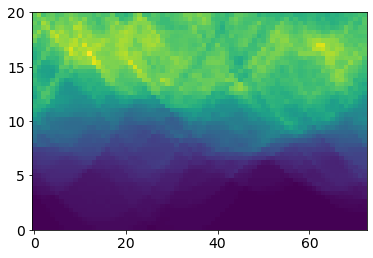

In [70]:
plt.figure()
plt.pcolormesh(np.arange(nsamp),edges[:-1]+0.5*dr,waveforms.T)


In [10]:
A=np.linspace(0,20,51)
dr=A[1]-A[0]

B=np.arange(0,20+dr,dr)
print(A.shape)
print(B.shape)

(51,)
(51,)


In [55]:
print(r[np.isfinite(r)].max())
print(r[np.isfinite(r)].min())

560024.202695912
559989.8799936043


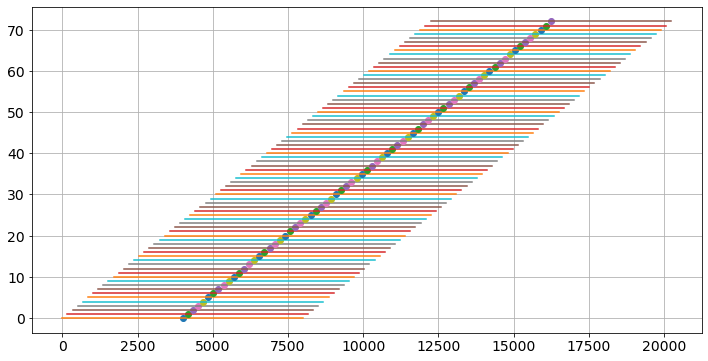

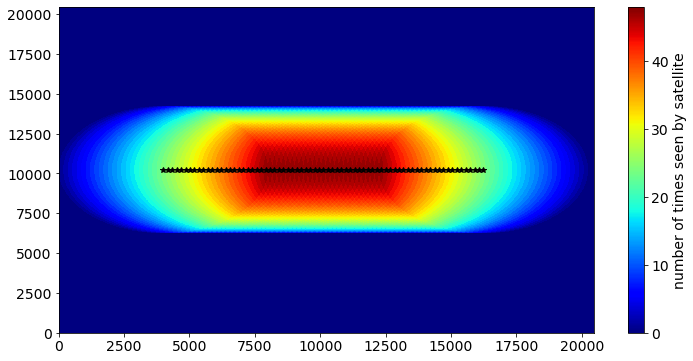

In [41]:
## ----- investigate overlapping ---------------------------
plt.figure(figsize=(12,6))
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    Xalt_rad = X[ialt-nxa:ialt+nxa+1]
    plt.plot(Xalt,isamp,'o')
    plt.plot(Xalt_rad,isamp*np.ones(Xalt_rad.shape),'-')
plt.grid(True)

nb_times_seen = np.zeros(S1_Gaussian.shape)
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    nb_times_seen[ialt-nxa:ialt+nxa+1,ny_mid-nxa:ny_mid+nxa+1] = nb_times_seen[ialt-nxa:ialt+nxa+1,ny_mid-nxa:ny_mid+nxa+1] +footprint

plt.figure(figsize=(12,6))
im=plt.pcolormesh(X,Y,nb_times_seen.T,cmap='jet')
plt.colorbar(im,label='number of times seen by satellite')
Yalt=Y[ny_mid]
for isamp in range(nsamp):
    ialt=(nxa+isamp*di).astype(int)
    Xalt = X[ialt]
    plt.plot(Xalt,Yalt,'*k')

In [76]:
## ---- print some dimensions and values to investigate links ---------------
# N.B.: easier with nx != ny
print('nx, ny = ',nx,' , ',ny)
print('X, Y = ',np.shape(X),' , ',np.shape(Y))
print('maxX, maxY = ',X.max(),' , ',Y.max())
print('kX0, kY0 = ',np.shape(np.unique(kX)),' , ',np.shape(kY0))
print('kX, kY = ',np.shape(kX),' , ',np.shape(kY))
print('shape Z1 = ',np.shape(Z1_PM))
print('shape rg =  ',np.shape(rg))#,' , ',np.shape(dky))
# ny = Z1.shape[0]
# nx = Z1.shape[1]
print('dkx = ',dkx,' =?= ',kX0[1] - kX0[0])
print('dx = ',dx,' =?= ',np.floor(2*np.pi/((kX0[1] - kX0[0])*nx)))
dx2 = (2*np.pi/((kX0[1] - kX0[0])*nx))
print('dkx = ',dkx,' =?= ',kX0[1] - kX0[0],' =?= ',2*np.pi/(dx2*nx))
print(kp)

nx, ny =  2048  ,  2048
X, Y =  (2048,)  ,  (2048,)
maxX, maxY =  20470  ,  20470
kX0, kY0 =  (2048,)  ,  (2048,)
kX, kY =  (2048, 2048)  ,  (2048, 2048)
shape Z1 =  (2048, 2048)
shape rg =   (2048, 2048)
dkx =  0.00030679615757712823  =?=  0.0003067961575771161
dx =  10  =?=  10.0
dkx =  0.00030679615757712823  =?=  0.0003067961575771161  =?=  0.0003067961575771161
0.01006075885537153


kx2D[0,0]= 0.0
ky2D[0,0]= 0.0
1023.0


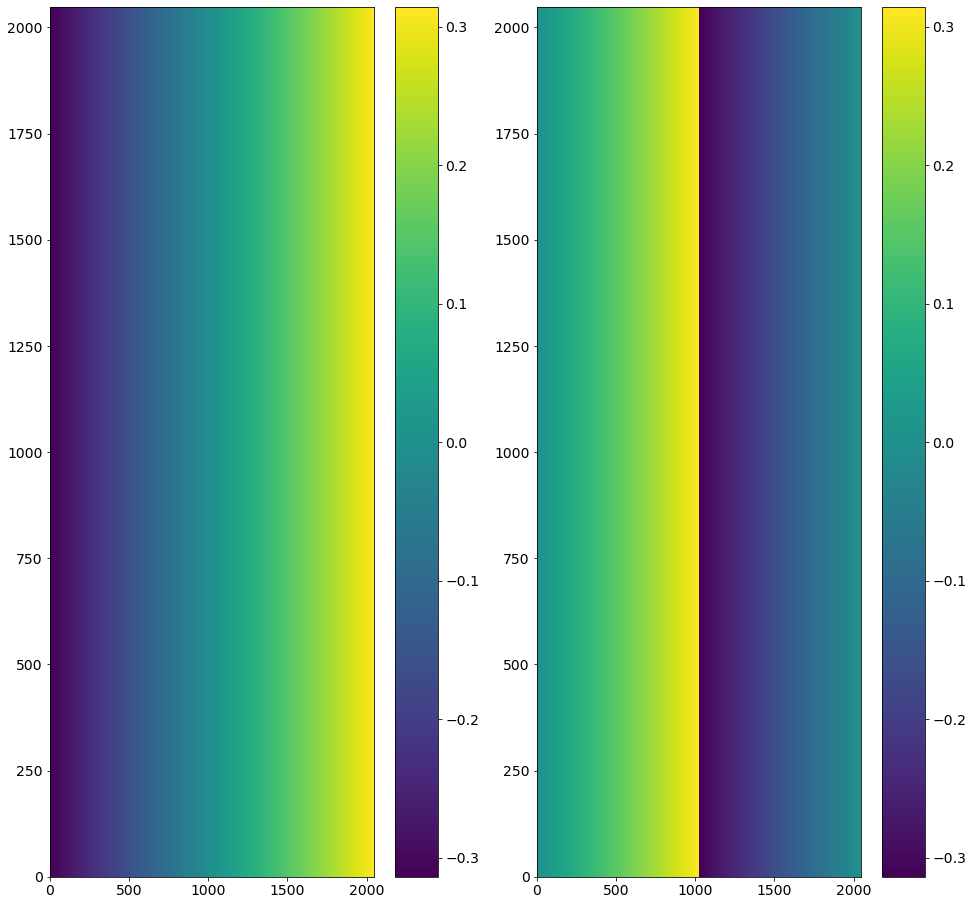

In [23]:
### ---- investigations on np.roll ------------------------------------
ky2D=np.roll(kY,(-int(shy),-int(shx)),axis=(0,1)) # checks that ky2D(1,1)=0 ... 
kx2D=np.roll(kX,(-int(shy),-int(shx)),axis=(0,1))# -int(shx),axis=1) # checks that kx2D(1,1)=0 ... 
print('kx2D[0,0]=',kx2D[0,0])
print('ky2D[0,0]=',ky2D[0,0])
print(shx)
fig,axs=plt.subplots(1,2,figsize=(16,8))

im=axs[0].pcolormesh(kX,cmap='viridis',norm = mcolors.Normalize(vmin=kX.min(), vmax=kX.max()))
plt.colorbar(im,ax=axs[0])

im=axs[1].pcolormesh(kx2D,cmap='viridis',norm = mcolors.Normalize(vmin=kx2D.min(), vmax=kx2D.max()))
plt.colorbar(im,ax=axs[1])

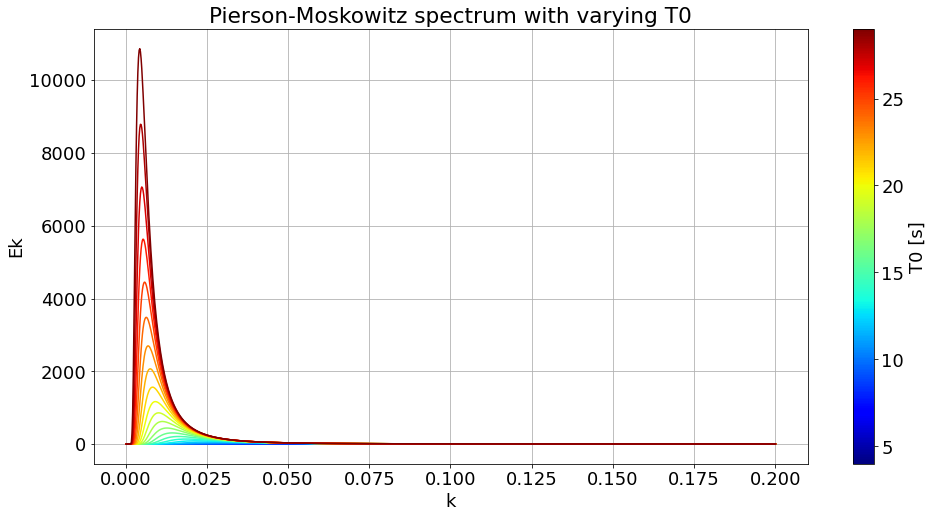

In [8]:
# ---------- Pierson Moskowitz Spectrum depending on T0 ------------

T0s = np.arange(4,30)
nk = 1001
k=np.linspace(0.0002,0.2,nk)

plt.figure(figsize=(16,8))
colors = plt.cm.jet(np.linspace(0,1,len(T0s)))
cNorm  = mcolors.Normalize(vmin=T0s[0], vmax=T0s[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='jet')
for iT0 in range(len(T0s)):
    Ek = PM_spectrum_k(k,1/T0s[iT0],D=D)
    _=plt.plot(k,Ek,'-',color=colors[iT0])
_=plt.grid(True)
_=plt.xlabel('k')
_=plt.ylabel('Ek')
_=plt.colorbar(scalarMap,label='T0 [s]')
_=plt.title('Pierson-Moskowitz spectrum with varying T0')

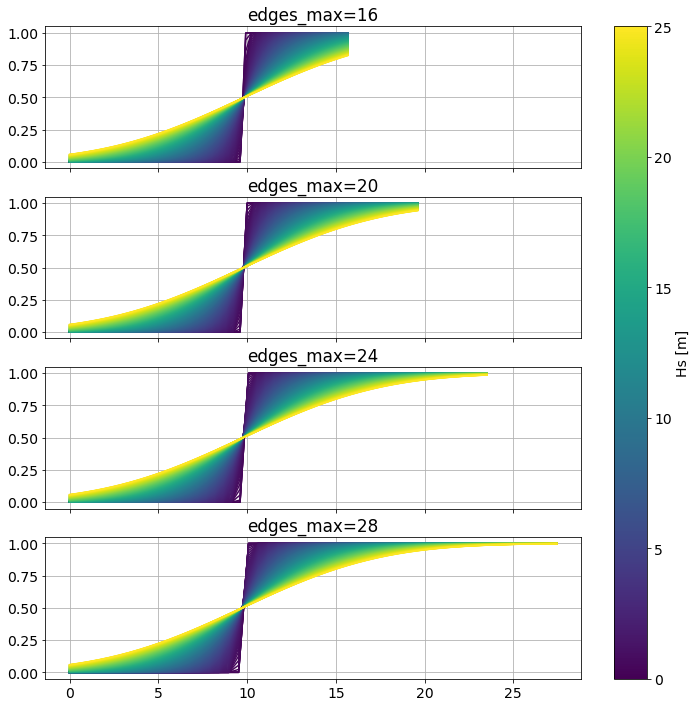

In [24]:
## ---- investigate differences in terms of edges.max() -------- 
colors = plt.cm.viridis(np.linspace(0,1,nHs))
cNorm  = mcolors.Normalize(vmin=Hsm.min(), vmax=Hsm.max())
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap='viridis')

fig,axs=plt.subplots(4,1,figsize=(12,12),sharex=True)
for ned in range(4):
    wfm, Hsm, edges = generate_wvform_database(ne,nHs,edges_max=16+ned*4,Hs_max=25)
    for k in range(nHs):
        _=axs[ned].plot(edges[:-1],wfm[k,:],color=colors[k])
    tit = 'edges_max='+str(16+ned*4)
    axs[ned].set_title(tit)
    axs[ned].grid(True)

_=plt.grid(True)
_=plt.colorbar(scalarMap,label='Hs [m]',ax=axs[:])



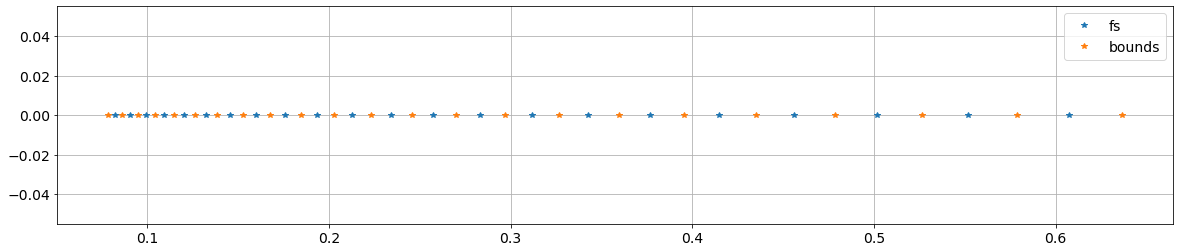

In [82]:
## --- geometrical expansion for frequency (microbaroms)
fo = 0.082038
xfr = 1.1
n = np.arange(0,22)
fn = fo *xfr**n
fn2 = np.zeros((len(fn)+1))
fn2[0] = fn[0]/np.sqrt(xfr)
fn2[1:] = fn * np.sqrt(xfr)
plt.figure(figsize=(20,4))
plt.plot(fn,np.zeros(fn.shape),'*',label='fs')
plt.plot(fn2,np.zeros(fn2.shape),'*',label='bounds')
plt.grid(True)
plt.legend()

In [4]:
## --- Read and investigate L1a data ---------------------
import xarray as xr
filenc='/home/datawork-cersat-public/provider/cnes/satellite/l1a/cfosat/swim/swi_l1a___/op05/5.1.2/2020/002/CFO_OP05_SWI_L1A____F_20200102T002637_20200102T020004.nc'
ds=xr.open_dataset(filenc,decode_times=False)
plt.plot(ds.isel(n_mcycles=15).radar_range_0,ds.isel(n_mcycles=15).echo_l1a_0,'.')
plt.grid(True)
ds

NameError: name 'plt' is not defined

In [5]:
ds

KeyboardInterrupt: 

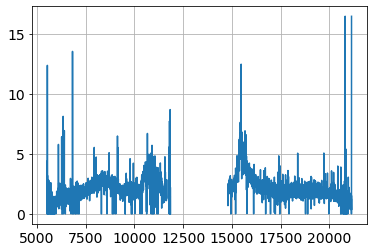

In [37]:
## ---- Read and investigate L2 data --------------------------
filenc='/home/datawork-cersat-public/provider/cnes/satellite/l2/cfosat/swim/swi_l2____/op05/5.1.2/2020/002/CFO_OP05_SWI_L2_____F_20200102T002637_20200102T020004.nc'
dsL2=xr.open_dataset(filenc,decode_times=False)
plt.plot(dsL2.nadir_swh_native,dsL2.nadir_swh_native)
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
nbcycle = 16000
# plt.plot(np.diff(ds.isel(n_mcycles=nbcycle).radar_range_0))


plt.plot(ds.isel(n_mcycles=nbcycle).radar_range_0,ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)
plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle).ground_range_0,ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)
print(ds.isel(n_mcycles=nbcycle).ground_range_0.data)

plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle).echo_l1a_0,'.')
plt.grid(True)

plt.figure()
plt.plot(ds.isel(n_mcycles=nbcycle,n_beam0=0).echo_l1_0,'.')
plt.grid(True)

# dx = 0.374